In [1]:

import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore
import pandas as pd # type: ignore
from tqdm import tqdm
import jax
import jax.numpy as jnp  # type: ignore
import parametrization_cookbook.jax as pc  # type: ignore
import pickle 
import seaborn as sns

import sys
import platform
import pkg_resources
from typing import NamedTuple



In [2]:
from jax import config
config.update("jax_enable_x64", True)

import model as model
import mixed_model as md
import mixed_modelH0 as md0

In [3]:

# Version de Python
print("Version de Python:", sys.version)

# Version de l'OS
print("Système d'exploitation:", platform.system(), platform.release())

# Liste des versions des packages installés
print("\nVersions des bibliothèques installées:")
installed_packages = pkg_resources.working_set
for package in sorted(installed_packages, key=lambda x: x.project_name.lower()):
    print(f"{package.project_name}=={package.version}")

Version de Python: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
Système d'exploitation: Windows 10

Versions des bibliothèques installées:
asttokens==2.4.1
bibtexparser==1.4.1
colorama==0.4.6
comm==0.2.2
contourpy==1.2.0
cycler==0.12.1
debugpy==1.8.1
decorator==5.1.1
et-xmlfile==1.1.0
executing==2.0.1
fonttools==4.50.0
ipykernel==6.29.4
ipython==8.22.2
jax==0.4.26
jaxlib==0.4.26
jedi==0.19.1
jupyter-client==8.6.1
jupyter-core==5.7.2
kiwisolver==1.4.5
matplotlib==3.8.3
matplotlib-inline==0.1.6
ml-dtypes==0.3.2
nest-asyncio==1.6.0
numpy==1.26.4
openpyxl==3.1.5
opt-einsum==3.3.0
packaging==24.0
pandas==2.2.1
parametrization-cookbook==0.18
parso==0.8.3
pillow==10.2.0
pip==24.0
platformdirs==4.2.0
prompt-toolkit==3.0.43
psutil==5.9.8
pure-eval==0.2.2
pygments==2.17.2
pyparsing==3.1.2
python-dateutil==2.9.0.post0
pytz==2024.1
pywin32==306
pyzmq==25.1.2
scipy==1.12.0
seaborn==0.13.2
setuptools==65.5.0
six==1.16.0
stack-data==0.6.3
tornado==6.4
tqdm==4.66.4


Some util functions for this notebook

In [4]:
def oneD_to_param(x, s=1):
    return s * jnp.log(1 + jnp.exp(x))


def list_of_states_to_output(list_of_states,estimation_description):
    return {
        output.name: jnp.array(
            [getattr(list_of_states[t], output.name) for t in output.times]
        )
        for output in estimation_description.outputs
    }


def data_mixed_arnica(nombre_indiv, param, seed, ndays = 25) :

    estimation_description_2 = md.EstimationDescription(
        indiv_model_parameters=md.estimation_description.indiv_model_parameters,
        population_model_parameters=(),
        outputs=(
            md.Output("TDW", tuple([i for i in range(ndays)])),
            md.Output("RDW", tuple([i for i in range(ndays)])),
            md.Output("TNQ", tuple([i for i in range(ndays)])),
            md.Output("QNStor", tuple([i for i in range(ndays)])),
            md.Output("LA", tuple([i for i in range(ndays)])),
            md.Output("PLA", tuple([i for i in range(ndays)])),
        ),
    )

    prng_key = jax.random.PRNGKey(seed)

    key, prng_key = jax.random.split(prng_key)

    # valeurs latentes des données simulées :
    latent_variate_all_star = jax.random.normal(key, shape = (nombre_indiv,estimation_description_2.nindiv))

    noise_out = {}
    for k, out in enumerate(estimation_description_2.outputs):

        key, prng_key = jax.random.split(prng_key)
        noise = jnp.sqrt((param.residual_var[k])) * jax.random.normal(
            key, shape=(nombre_indiv, len(out.times))
        )
        noise_out[out.name] = noise

    output = []

    for i in range(nombre_indiv):

        params_model_indiv = md.base_params_model.get_params_model_indiv(
            estimation_description_2, param, latent_variate_all_star[i]
        )

        list_of_state = md.run(
            params_model=params_model_indiv,
            n_days=ndays,
        )

        new_out = list_of_states_to_output(list_of_state, estimation_description_2)


        output.append(
            {
                out_name: out_val *jnp.exp( noise_out[out_name][i])
                for out_name, out_val in new_out.items()
            }
        )

    return latent_variate_all_star, output


class ResSgd(NamedTuple):

    z1: jnp.ndarray
    z0: jnp.ndarray
    theta1: jnp.ndarray
    theta0: jnp.ndarray

    

def single_estimation(seed, y):
    # Génération de la clé PRNGKey à partir de la seed donnée
    key = jax.random.PRNGKey(seed)
    
    # Estimation des paramètres avec la fonction estim_param
    return md.estim_param(
        jax.random.normal(key, shape=(md.parametrization.size,)),
        y,
        seed,
        N_max=750,
        beta=0.9,
        end_heat_step=300,
        pre_heat=50,
    )

def simulation_estimation(seed, param) :
    latent_variate_all_star, y_simulated = data_mixed_arnica(48, param, seed)
    # dates d'observation
    for y in y_simulated:
        for k in y.keys():
            y[k] = y[k][jnp.array([10, 17, 21])]

    return(latent_variate_all_star, y_simulated, single_estimation(seed, y_simulated))


def single_estimation0(seed, y):
    # Génération de la clé PRNGKey à partir de la seed donnée
    key = jax.random.PRNGKey(seed)
    
    # Estimation des paramètres avec la fonction estim_param
    return md0.estim_param(
        jax.random.normal(key, shape=(md0.parametrization.size,)),
        y,
        seed,
        N_max=750,
        beta=0.9,
        end_heat_step=300,
        pre_heat=50,
    )

def simulation_estimation0(seed, param) :
    latent_variate_all_star, y_simulated = data_mixed_arnica(48, param, seed)
    # dates d'observation
    for y in y_simulated:
        for k in y.keys():
            y[k] = y[k][jnp.array([10, 17, 21])]

    return(latent_variate_all_star, y_simulated, single_estimation0(seed, y_simulated))

Parameter values

In [5]:

loc = jnp.array([getattr(md.base_params_model, p).parametrization.params_to_reals1d(getattr(md.base_params_model, p).default_value) for p in md.estimation_description.indiv_model_parameters]).reshape(md.estimation_description.nindiv,)
scale_diag = jnp.array([0.4, 0.2, 0., 0.]).reshape(md.estimation_description.nindiv,)

pop = jnp.array([getattr(md.base_params_model, p).parametrization.params_to_reals1d(getattr(md.base_params_model, p).default_value) for p in md.estimation_description.population_model_parameters]).reshape(md.estimation_description.npop,)

param_star = {"pop" : pop, "indiv" : {"loc" : loc, "scale" : jnp.diag(scale_diag)}, "residual_var" : jnp.array([1.0, 0.5, 0.08, 0.15, 0.5, 0.3,])/10}

param_1d_star = md.parametrization.params_to_reals1d(param_star)
param_star = md.parametrization.reals1d_to_params(param_1d_star)

index0 = jnp.array([2, 3, 0, 1, 4, 5] + [i for i in range(8, 14)])


In [13]:
seed = 0 
nexp = 100
prng_key =jax.random.PRNGKey(seed)
key, prng_key = jax.random.split(prng_key)
seed_liste = jax.random.randint(key, shape = (nexp,), minval=0, maxval=1000)

In [14]:
seed_liste

Array([185, 579, 903, 935, 938,  94, 803, 988, 424,   6, 934, 896, 617,
       891, 137, 714,  56, 238, 616, 879, 236, 514, 122, 179, 258,  68,
       284,  19,  96, 404, 259, 275, 967,  24, 966, 438,  82,  16, 870,
       685, 450, 505, 683, 611, 967, 931, 873, 136, 562, 827, 498, 653,
       636, 400,  38,  98, 404, 564, 978, 238, 750, 523, 269,  31, 861,
       156, 524, 181,  76, 546, 232, 503, 251, 212, 803, 218, 548, 832,
       629, 687, 714, 162, 678, 856, 454,  95, 194, 499,  54, 624, 649,
       677, 439, 650, 479, 707, 613, 731,  57, 438], dtype=int32)

In [15]:
res_diffdata = jax.vmap(simulation_estimation, in_axes=(0, None))(seed_liste, param_star)

heating phase :


100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


estimation :


100%|██████████| 750/750 [09:54<00:00,  1.26it/s] 


In [23]:
# with open('res_plot_data_diff/estim_simu.pkl', 'wb') as f:
#     pickle.dump(res_diffdata, f)

# with open('res_estim_simu.pkl', 'rb') as f:
#     res = pickle.load(f)

In [25]:
res_diffdataH0 = jax.vmap(simulation_estimation0, in_axes=(0, None))(seed_liste, param_star)

heating phase :


100%|██████████| 50/50 [00:25<00:00,  1.96it/s]


estimation :


100%|██████████| 750/750 [07:42<00:00,  1.62it/s] 


In [75]:
with open('res_plot_data_diffH0/estim_simu0.pkl', 'wb') as f:
    pickle.dump(res_diffdataH0, f)

# with open('res_estim_simu.pkl', 'rb') as f:
#     res = pickle.load(f)

In [26]:
#estimations_np = res_diffdata[2][1]
estimations_np = res_diffdataH0[2][1]

## PLOT

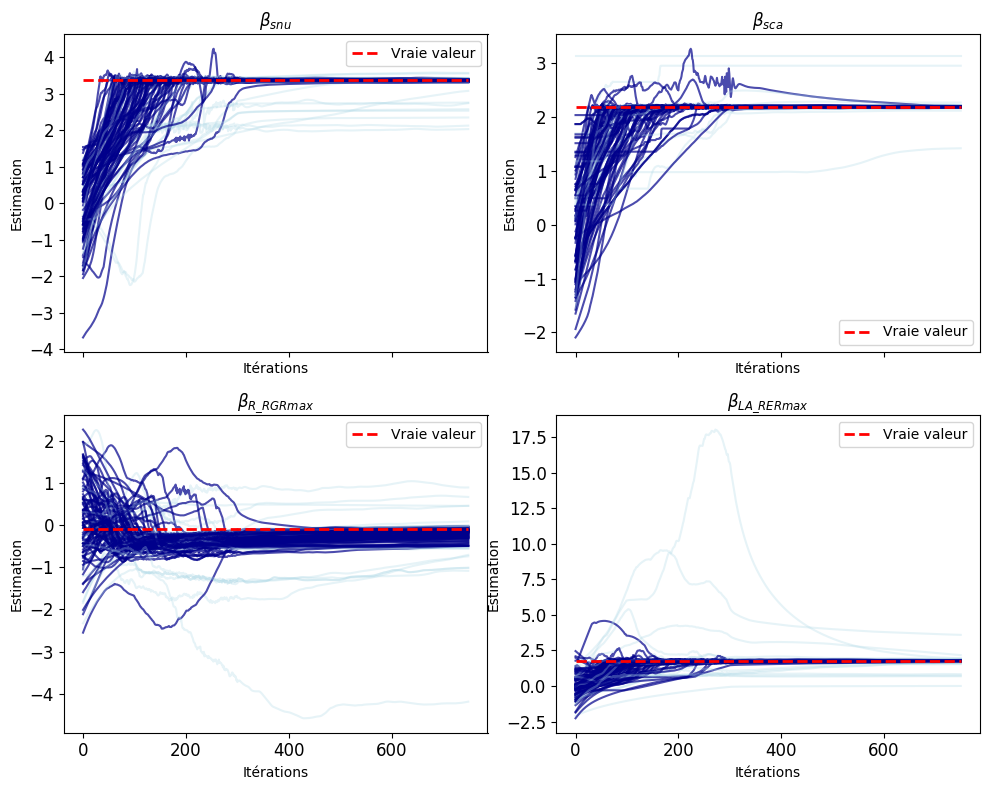

In [30]:


indices_beta = [0, 1, 2, 3]
b = len(indices_beta)

noms = [r'$\beta_{snu}$', r'$\beta_{sca}$', r'$\beta_{R\_RGRmax}$', r'$\beta_{LA\_RERmax}$']

# Créer une grille de graphes 2x2
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
axes = axes.flatten()

# Stocker les indices des courbes pour les utiliser plus tard
indices_courbes_in_beta = [[] for _ in range(b)]
indices_courbes_out_beta = [[] for _ in range(b)]

# Remplir les graphiques
for i in range(b):
    ax = axes[i]
    param_index = i
    data = estimations_np[:, :, param_index]  # Trajectoires complètes pour le paramètre i
    final_values = data[:, -1]  # Valeurs finales des trajectoires
    
    # Calculer les percentiles pour les valeurs finales
    p10, p90 = np.percentile(final_values, [10, 90])
    
    # Tracer chaque trajectoire
    for j in range(data.shape[0]):
        traj = data[j, :]
        final_value = traj[-1]
        
        if p10 <= final_value <= p90:
            ax.plot(traj, color='darkblue', alpha=0.7)
            indices_courbes_in_beta[i].append(j)
        else:
            ax.plot(traj, color='lightblue', alpha=0.3)
            indices_courbes_out_beta[i].append(j)

    # Ajouter la vraie valeur des paramètres
    #ax.plot([0, data.shape[1] - 1], [param_1d_star[param_index]] * 2, 'r--', label='Vraie valeur', linewidth=2)
    ax.plot([0, data.shape[1] - 1], [param_1d_star[index0][param_index]] * 2, 'r--', label='Vraie valeur', linewidth=2)
    ax.tick_params(axis='both', which='major', labelsize=12)  # Augmenter la taille des graduations

    ax.set_title(noms[i])
    ax.set_xlabel('Itérations')
    ax.set_ylabel('Estimation')
    ax.legend()

# Ajuster l'affichage
plt.tight_layout()
#plt.savefig("res_plot_data_diff/courbebetaplot.png", dpi=300)
plt.savefig("res_plot_data_diffH0/courbebetaplot.png", dpi=300)
plt.show()

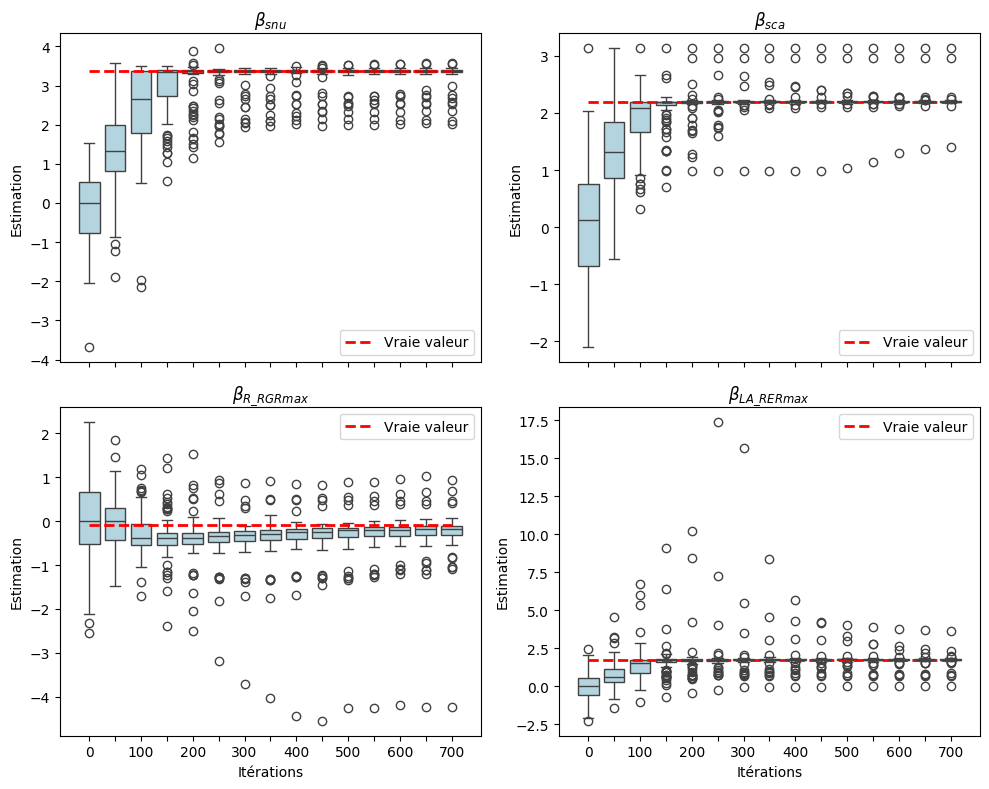

In [31]:
indices_beta  = [0, 1 ,2, 3]

b = len(indices_beta)

noms = [r'$\beta_{snu}$',
        r'$\beta_{sca}$',
        r'$\beta_{R\_RGRmax}$',
        r'$\beta_{LA\_RERmax}$',]


# Définir les paramètres pour les graphes
n_iter_intervals = 50  # Intervalles d'itérations
num_plots = b  # Nombre total de paramètres (14 dans ce cas)

# Créer une grille de graphes 14x1
fig, axes = plt.subplots(2, 2, figsize=(10, 2 * num_plots), sharex=True)

axes = axes.flatten()

# Préparer les indices d'itérations
iter_indices = np.arange(0, estimations_np.shape[1], n_iter_intervals)

# Remplir les graphiques
for i in range(num_plots):
    ax = axes[i]
    param_index = i
    data = [estimations_np[:, iter_index, param_index] for iter_index in iter_indices]
    
    # Créer les boxplots
    sns.boxplot(data=data, ax=ax, color = 'lightblue')
    # Ajouter la vraie valeur des paramètres
    #ax.plot([0, len(iter_indices) - 1], [param_1d_star[param_index]] * 2, 'r--', label='Vraie valeur', linewidth = 2)
    ax.plot([0, len(iter_indices) - 1], [param_1d_star[index0][param_index]] * 2, 'r--', label='Vraie valeur', linewidth = 2)

    xticks_labels = [str(iter_indices[j]) if j % 2 == 0 else '' for j in range(len(iter_indices))]
    ax.set_xticks(range(len(iter_indices)))
    ax.set_xticklabels(xticks_labels)

    ax.set_title(noms[i])
    ax.set_xlabel('Itérations')
    ax.set_ylabel('Estimation')
    ax.legend()

# Ajuster l'affichage
plt.tight_layout()
#plt.savefig("res_plot_data_diff/betaplot.png", dpi=300)
plt.savefig("res_plot_data_diffH0/betaplot.png", dpi=300)
plt.show()

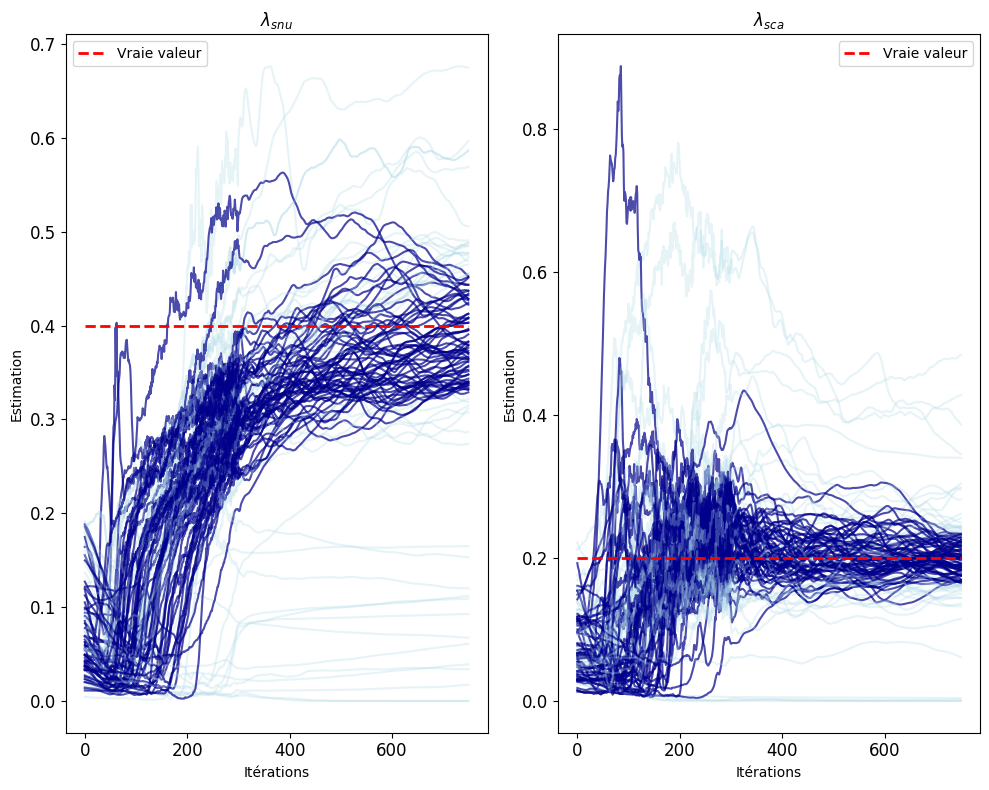

In [39]:
# Définir les indices des paramètres lambda
indices_lambda = [4, 5, 6, 7]
b = len(indices_lambda)

# noms = [r'$\lambda_{snu}$',
#         r'$\lambda_{sca}$',
#         r'$\lambda_{R\_RGRmax}$',
#         r'$\lambda_{LA\_RERmax}$',]
#H0 : 
noms = [r'$\lambda_{snu}$',
        r'$\lambda_{sca}$',]
b=len(noms)
# Créer une grille de graphes 2x2
#fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)

fig, axes = plt.subplots(1, 2, figsize=(10, 8), sharex=True)
axes = axes.flatten()

# Stocker les indices des courbes pour les utiliser plus tard
indices_courbes_in_lambda = [[] for _ in range(b)]
indices_courbes_out_lambda = [[] for _ in range(b)]

# Remplir les graphiques
for i in range(b):
    ax = axes[i]
    param_index = indices_lambda[i]
    data = estimations_np[:, :, param_index]
    
    # Transformation des données
    data_transfo = [jnp.array([oneD_to_param(e, s=0.1) for e in d]) for d in data]
    
    # Calculer les valeurs finales des trajectoires
    final_values = [d[-1] for d in data]
    transformed_final_values = jnp.array([oneD_to_param(v, s=0.1) for v in final_values])
    
    # Calculer les percentiles pour les valeurs finales transformées
    p20, p80 = np.percentile(transformed_final_values, [20, 80])
    
    # Tracer chaque trajectoire
    for j in range(len(data)):
        traj = data_transfo[j]
        final_value = transformed_final_values[j]
        
        if p20 <= final_value <= p80:
            ax.plot(traj, color='darkblue', alpha=0.7)
            indices_courbes_in_lambda[i].append(j)
        else:
            ax.plot(traj, color='lightblue', alpha=0.3)
            indices_courbes_out_lambda[i].append(j)

    # Ajouter la vraie valeur des paramètres
    #ax.plot([0, data.shape[1] - 1], [oneD_to_param(param_1d_star[param_index], s=0.1)] * 2, 'r--', label='Vraie valeur', linewidth=2)
    ax.plot([0, data.shape[1] - 1], [oneD_to_param(param_1d_star[index0][param_index], s=0.1)] * 2, 'r--', label='Vraie valeur', linewidth=2)
    ax.tick_params(axis='both', which='major', labelsize=12)  # Augmenter la taille des graduations

    ax.set_title(noms[i])
    ax.set_xlabel('Itérations')
    ax.set_ylabel('Estimation')
    ax.legend()

# Ajuster l'affichage
plt.tight_layout()
#plt.savefig("res_plot_data_diff/courbelambdaplot.png", dpi=300)
plt.savefig("res_plot_data_diffH0/courbelambdaplot.png", dpi=300)
plt.show()

# Maintenant, les indices_courbes_in et indices_courbes_out contiennent les indices des courbes respectives


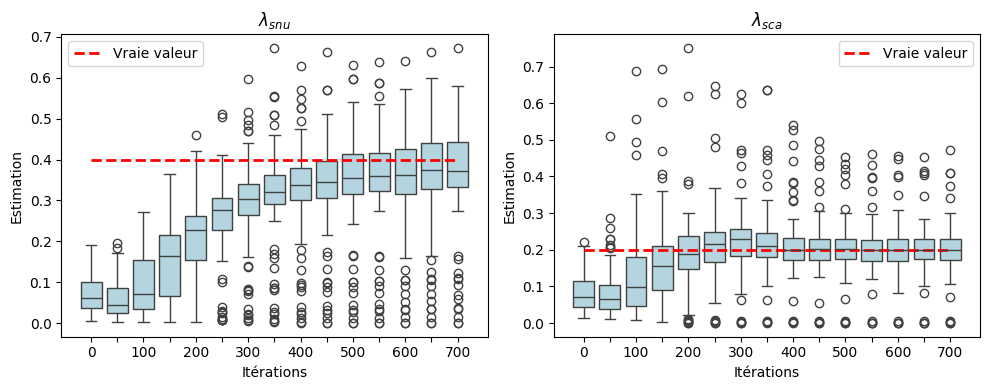

In [36]:
indices_lambda = [4, 5, 6, 7]

b = len(indices_lambda)

# noms = [r'$\lambda_{snu}$',
#         r'$\lambda_{sca}$',
#         r'$\lambda_{R\_RGRmax}$',
#         r'$\lambda_{LA\_RERmax}$',]
#H0 : 
noms = [r'$\lambda_{snu}$',
        r'$\lambda_{sca}$',]
b=len(noms)
# Définir les paramètres pour les graphes
n_iter_intervals = 50  # Intervalles d'itérations
num_plots = b  # Nombre total de paramètres (14 dans ce cas)

# Créer une grille de graphes 14x1
#fig, axes = plt.subplots(2, 2, figsize=(10, 2 * num_plots), sharex=True)
fig, axes = plt.subplots(1, 2, figsize=(10, 2 * num_plots), sharex=True)
axes = axes.flatten()

# Préparer les indices d'itérations
iter_indices = np.arange(0, estimations_np.shape[1], n_iter_intervals)

# Remplir les graphiques
for i in range(num_plots):
    ax = axes[i]
    param_index = 4 + i
    data = [estimations_np[:, iter_index, param_index] for iter_index in iter_indices]
    data_transfo = [ jnp.array([ oneD_to_param(e, s=0.1) for e in d]) for d in data ]
    # Créer les boxplots
    sns.boxplot(data=data_transfo, ax=ax, color = 'lightblue')
    # Ajouter la vraie valeur des paramètres
    #ax.plot([0, len(iter_indices) - 1], [oneD_to_param(param_1d_star[param_index], s=0.1)] * 2, 'r--', label='Vraie valeur', linewidth = 2)
    ax.plot([0, len(iter_indices) - 1], [oneD_to_param(param_1d_star[index0][param_index], s=0.1)] * 2, 'r--', label='Vraie valeur', linewidth = 2)
    
    xticks_labels = [str(iter_indices[j]) if j % 2 == 0 else '' for j in range(len(iter_indices))]
    ax.set_xticks(range(len(iter_indices)))
    ax.set_xticklabels(xticks_labels)

    
    ax.set_title(noms[i])
    ax.set_xlabel('Itérations')
    ax.set_ylabel('Estimation')
    ax.legend()

# Ajuster l'affichage
plt.tight_layout()
#plt.savefig("res_plot_data_diff/lambdaplot.png", dpi=300)
plt.savefig("res_plot_data_diffH0/lambdaplot.png", dpi=300)
plt.show()

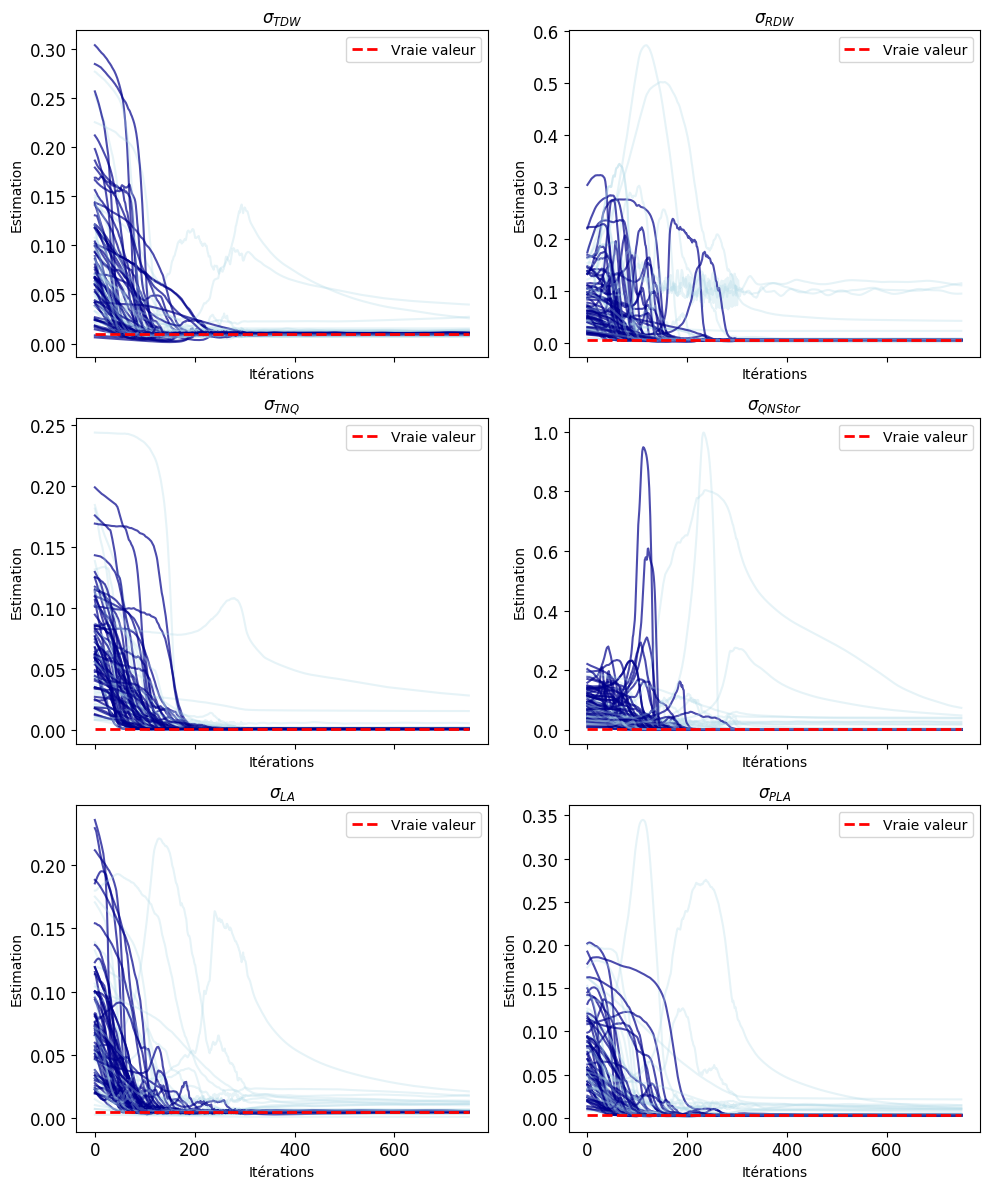

In [37]:

# Définir les indices des paramètres sigma
#indices_res = [8, 9, 10, 11, 12, 13]
indices_res = [6, 7, 8, 9, 10, 11]
b = len(indices_res)

noms = [r'$\sigma_{TDW}$', r'$\sigma_{RDW}$', r'$\sigma_{TNQ}$', r'$\sigma_{QNStor}$', r'$\sigma_{LA}$', r'$\sigma_{PLA}$']

# Créer une grille de graphes 3x2
fig, axes = plt.subplots(3, 2, figsize=(10, 2 * b), sharex=True)
axes = axes.flatten()

# Stocker les indices des courbes pour les utiliser plus tard
indices_courbes_in_sigma = [[] for _ in range(b)]
indices_courbes_out_sigma = [[] for _ in range(b)]


# Remplir les graphiques
for i in range(b):
    ax = axes[i]
    param_index = indices_res[i]
    data = estimations_np[:, :, param_index]
    
    # Transformation des données
    data_transfo = [jnp.array([oneD_to_param(e, s=0.1) for e in d]) for d in data]
    
    # Calculer les valeurs finales des trajectoires
    final_values = [d[-1] for d in data]
    transformed_final_values = jnp.array([oneD_to_param(v, s=0.1) for v in final_values])
    
    # Calculer les percentiles pour les valeurs finales transformées
    p20, p80 = np.percentile(transformed_final_values, [20, 80])
    
    # Tracer chaque trajectoire
    for j in range(len(data)):
        traj = data_transfo[j]
        final_value = transformed_final_values[j]
        
        if p20 <= final_value <= p80:
            ax.plot(traj, color='darkblue', alpha=0.7)
            indices_courbes_in_sigma[i].append(j)
        else:
            ax.plot(traj, color='lightblue', alpha=0.3)
            indices_courbes_out_sigma[i].append(j)

    # Ajouter la vraie valeur des paramètres
    #ax.plot([0, data.shape[1] - 1], [oneD_to_param(param_1d_star[param_index], s=0.1)] * 2, 'r--', label='Vraie valeur', linewidth=2)
    ax.plot([0, data.shape[1] - 1], [oneD_to_param(param_1d_star[index0][param_index], s=0.1)] * 2, 'r--', label='Vraie valeur', linewidth=2)
    ax.tick_params(axis='both', which='major', labelsize=12)  # Augmenter la taille des graduations
    ax.set_title(noms[i])
    ax.set_xlabel('Itérations')
    ax.set_ylabel('Estimation')
    ax.legend()

# Ajuster l'affichage
plt.tight_layout()
#plt.savefig("res_plot_data_diff/courbesigmaplot.png", dpi=300)
plt.savefig("res_plot_data_diffH0/courbesigmaplot.png", dpi=300)
plt.show()


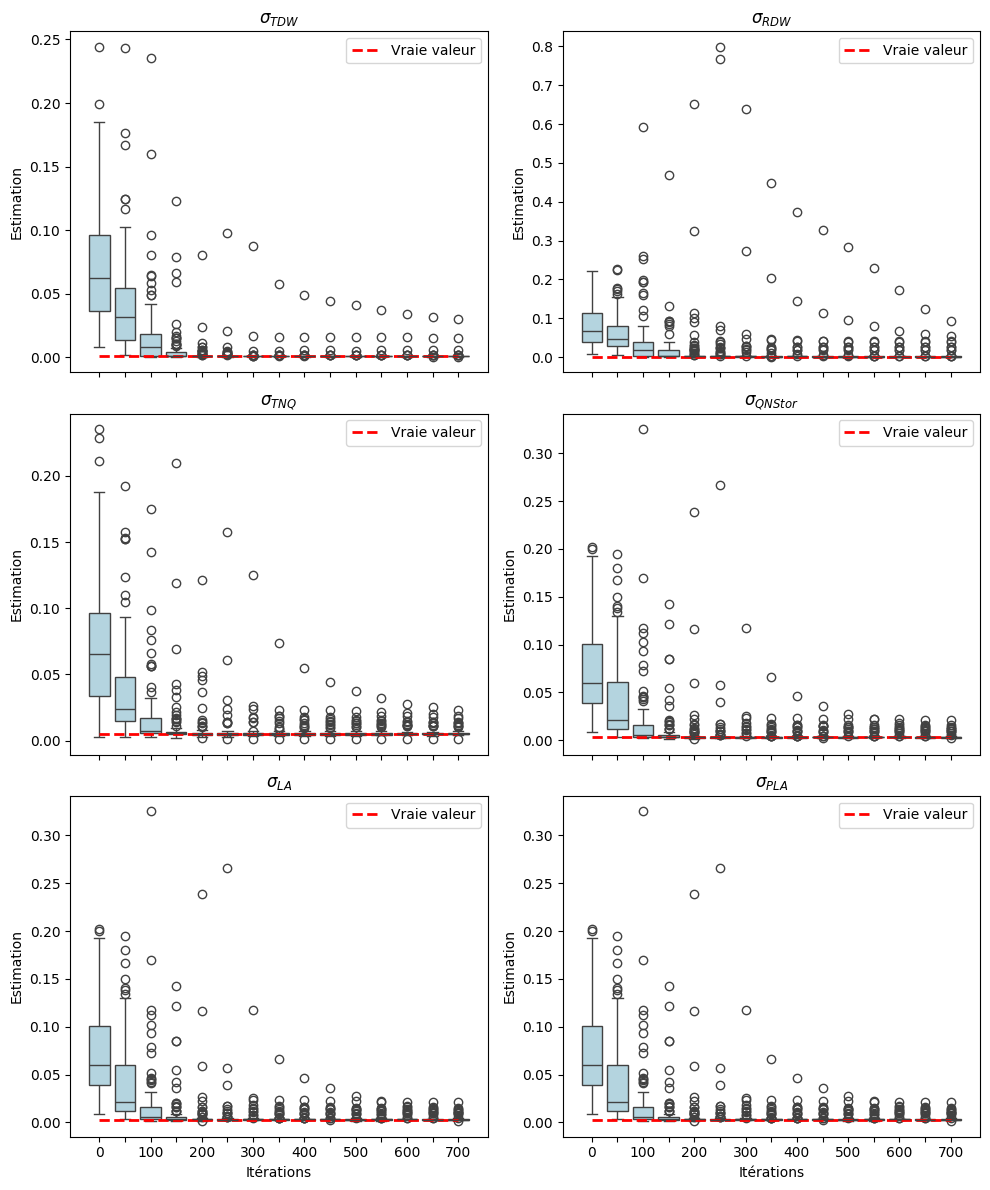

In [38]:
#indices_res = [8, 9, 10, 11, 12, 13]
indices_res = [6, 7, 8, 9, 10, 11]
b = len(indices_res)

noms = [r'$\sigma_{TDW}$',
        r'$\sigma_{RDW}$',
        r'$\sigma_{TNQ}$',
        r'$\sigma_{QNStor}$',
        r'$\sigma_{LA}$',
        r'$\sigma_{PLA}$',]


# Définir les paramètres pour les graphes
n_iter_intervals = 50  # Intervalles d'itérations
num_plots = b  # Nombre total de paramètres (14 dans ce cas)

# Créer une grille de graphes 14x1
fig, axes = plt.subplots(3, 2, figsize=(10, 2 * num_plots), sharex=True)

axes = axes.flatten()

# Préparer les indices d'itérations
iter_indices = np.arange(0, estimations_np.shape[1], n_iter_intervals)

# Remplir les graphiques
for i in range(num_plots):
    ax = axes[i]
    param_index = 8 + i
    data = [estimations_np[:, iter_index, param_index] for iter_index in iter_indices]
    data_transfo = [ jnp.array([ oneD_to_param(e, s=0.1) for e in d]) for d in data ]
    # Créer les boxplots
    sns.boxplot(data=data_transfo, ax=ax, color = 'lightblue')
    # Ajouter la vraie valeur des paramètres
    #ax.plot([0, len(iter_indices) - 1], [oneD_to_param(param_1d_star[param_index], s=0.1)] * 2, 'r--', label='Vraie valeur', linewidth = 2)
    ax.plot([0, len(iter_indices) - 1], [oneD_to_param(param_1d_star[index0][param_index], s=0.1)] * 2, 'r--', label='Vraie valeur', linewidth = 2)
    
    xticks_labels = [str(iter_indices[j]) if j % 2 == 0 else '' for j in range(len(iter_indices))]
    ax.set_xticks(range(len(iter_indices)))
    ax.set_xticklabels(xticks_labels)

    
    ax.set_title(noms[i])
    ax.set_xlabel('Itérations')
    ax.set_ylabel('Estimation')
    ax.legend()

# Ajuster l'affichage
plt.tight_layout()
#plt.savefig("res_plot_data_diff/sigmaplot.png", dpi=300)
plt.savefig("res_plot_data_diffH0/sigmaplot.png", dpi=300)
plt.show()


# SARIS

  0%|          | 0/750 [00:00<?, ?it/s]

100%|██████████| 750/750 [00:30<00:00, 24.34it/s]


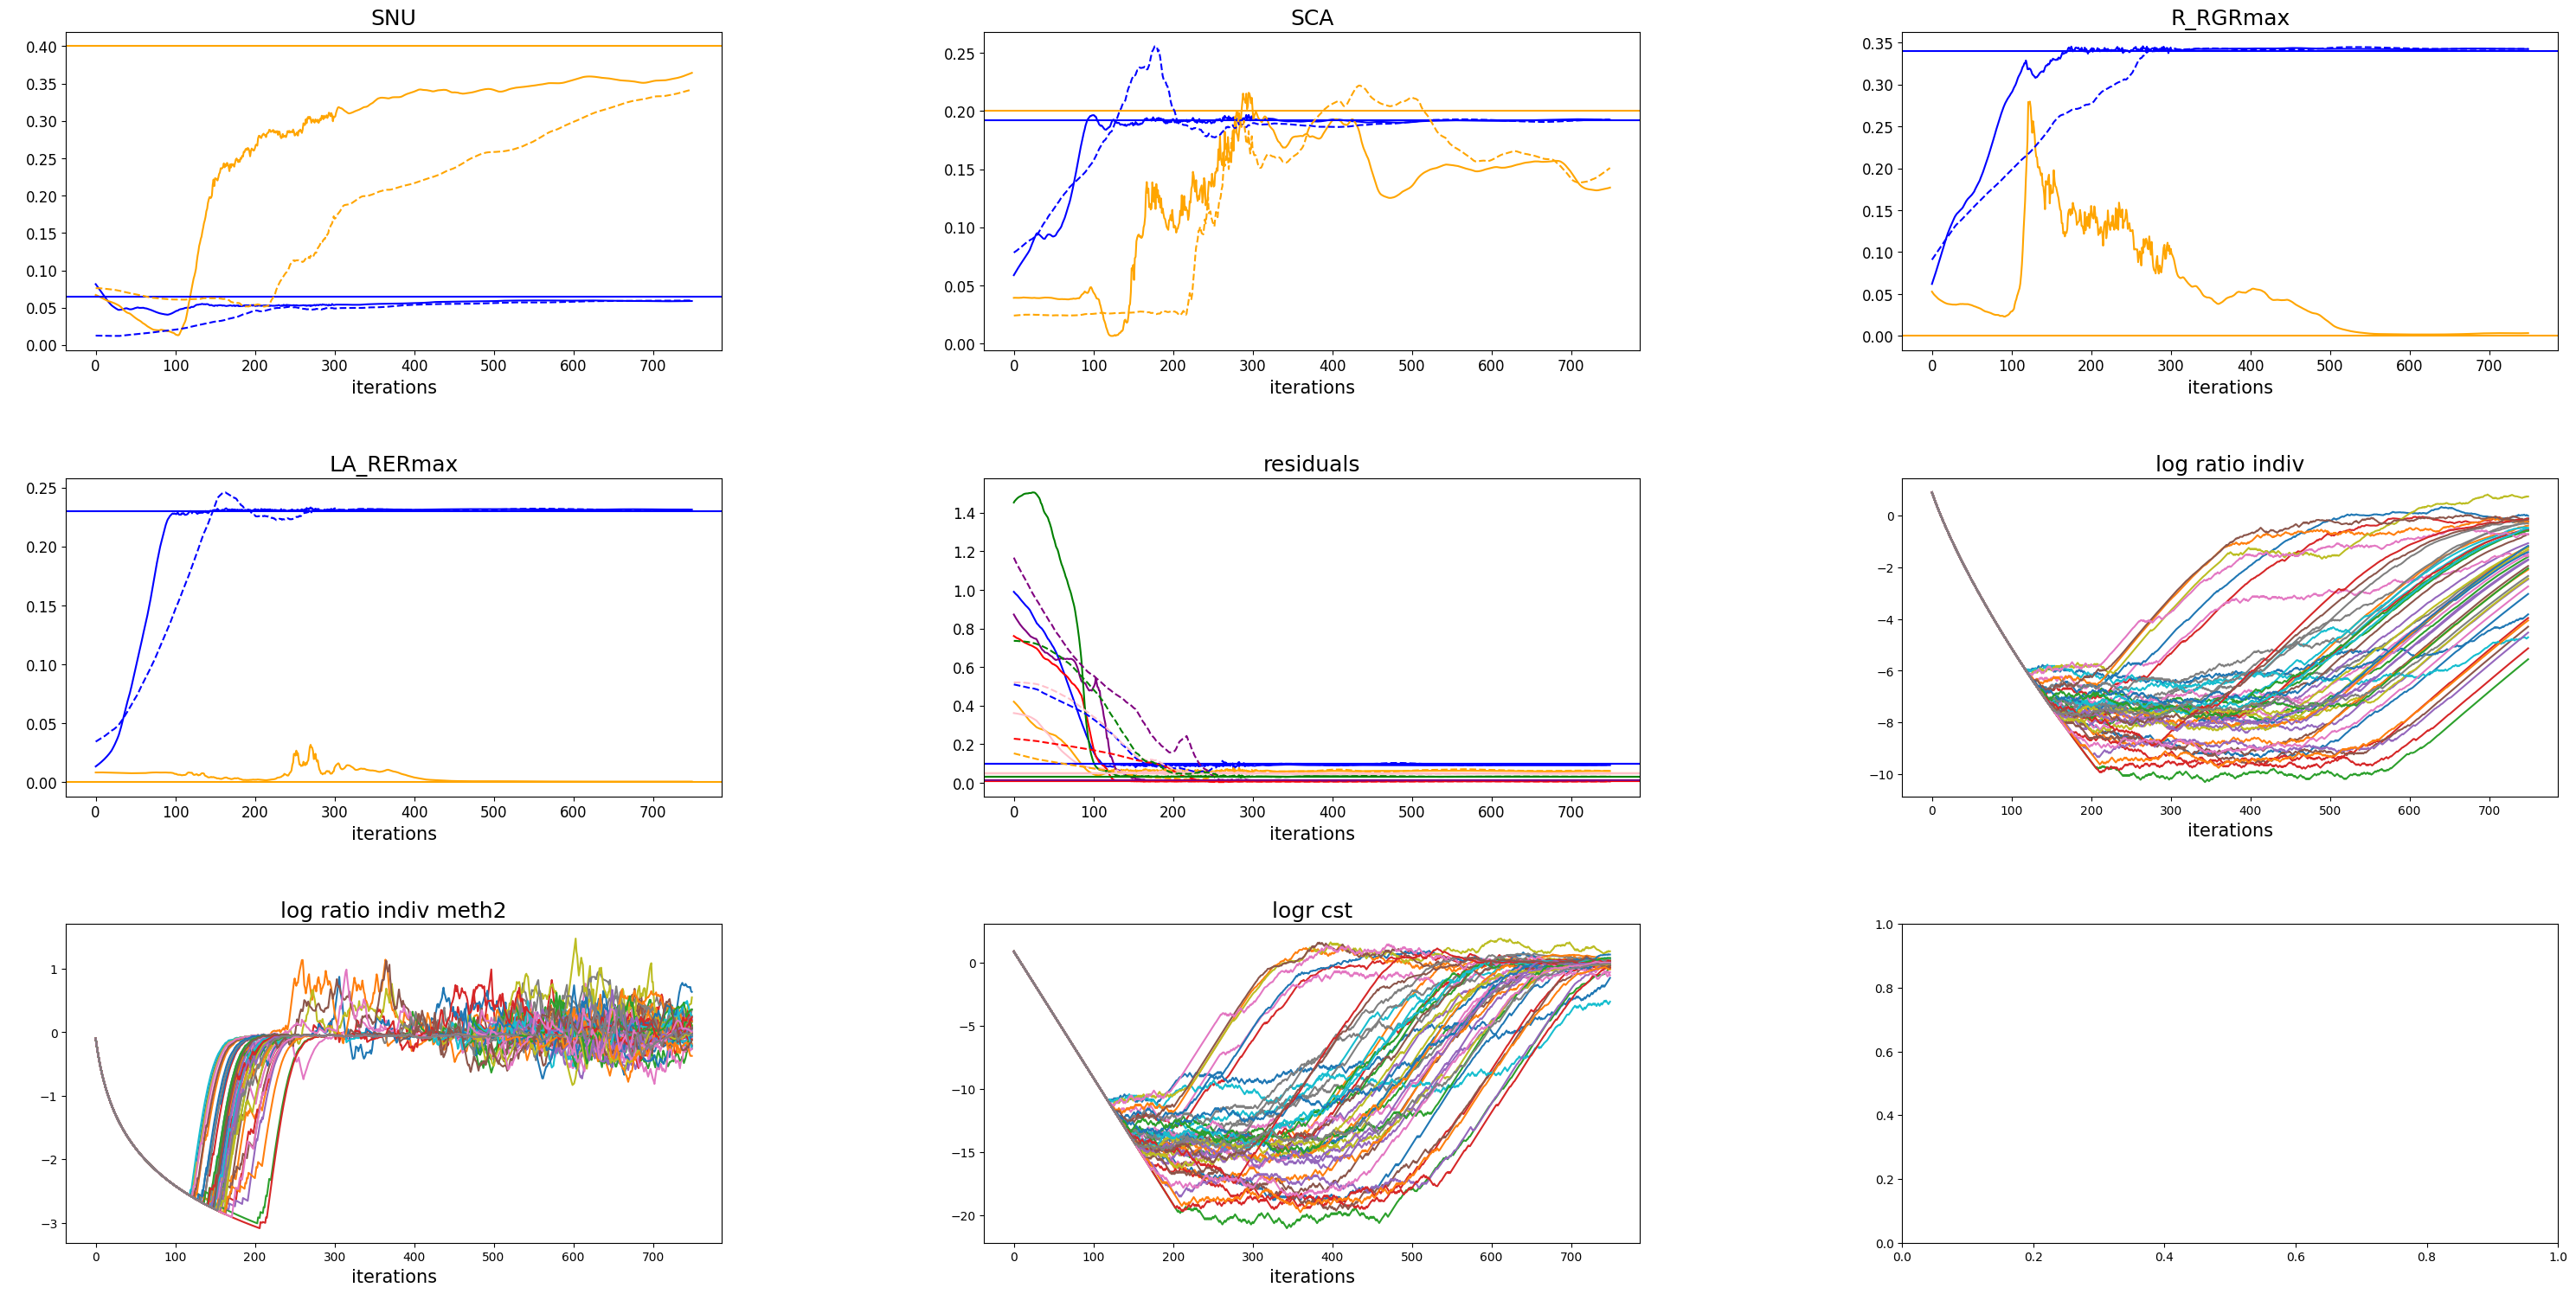

In [35]:
logr_liste = []
logr_liste2 = []
logr_liste_cst = []


H_liste = []
f0_liste = []
f1_liste = []
prng_key = jax.random.PRNGKey(seed)

n=48
N_max = 750
#N_max=1500
# N_begin = 50
N_begin = 0

r = jnp.ones((n, )) 
rcst = jnp.ones((n, )) 
r2 = jnp.zeros((n, ))
# key, prng_key = jax.random.split(prng_key)
# r = jax.random.normal(key, (n, )) 
# key, prng_key = jax.random.split(prng_key)
# rcst = jax.random.normal(key, (n, )) 
# key, prng_key = jax.random.split(prng_key)
# r2 = jax.random.normal(key, (n, ))   




gamma = 0.1

diff_dim = 2

zero_col = jnp.zeros((n,diff_dim))

seed = 10 

for step in tqdm(range(N_begin, N_max)):
    z1, z0, theta, theta0 = z1_ar[step], z0_ar[step], res1[2].theta[step], res0[2].theta[step]
    #z1, z0, theta, theta0 = z1_ar[step], z0_ar[step], res1.theta[step], res0.theta[step]
    # z1, z0, theta, theta0 = z1_ar[step], z0_ar[step], theta_avg[step], theta0_avg[step]

    
    key, prng_key = jax.random.split(prng_key)

    # mask par individu, pour choix z0 ou z1
    mask_ll = jax.random.uniform(key=key, shape=(n, ))>0.5
    mask_ll_ext = jnp.expand_dims(mask_ll, axis=1)


    # Concatenation de la colonne de zéros à z0 (\Theta0 -> \Theta)
    z_new = jax.random.normal(key, shape = (n, diff_dim))
    z0_extended = jnp.concatenate((z0, z_new), axis=1)

    z_saris = jnp.where(mask_ll_ext, z0_extended, z1)
    z_saris_reduced = jnp.delete(z_saris, jnp.array([-1, -2]), axis=1)
    z1_reduced = jnp.delete(z1, jnp.array([-1, -2]), axis=1)


    z_ad = jnp.where(mask_ll_ext, z_new, z1[:, jnp.array([-2,-1])])

    logf0 = md0.log_lik_rows(theta0, z_saris_reduced, y_sim) - 0.5*diff_dim*jnp.log(2*jnp.pi) - 0.5 * jnp.sum(z_ad**2, axis = 1)
    logf1 = md.log_lik_rows(theta, z_saris, y_sim) 


    mask_computo = logf1>logf0
    f0 = jnp.where(mask_computo, jnp.exp(logf0 - logf1), 1)
    f1 = jnp.where(mask_computo, 1, jnp.exp(logf1 - logf0))
    # f0 = jnp.exp(logf0)
    # f1 = jnp.exp(logf1)

    H = (f0 - jnp.exp(r) * f1) / (f0 + jnp.exp(r) * f1)
    H_liste.append(H)
    r += (gamma/(1+0.1*step**0.51))* H
    rcst+= gamma * (f0 - jnp.exp(rcst) * f1) / (f0 + jnp.exp(rcst) * f1)

    if jnp.isnan(r).any():
        break

    ll1at0 = md.log_lik_rows(theta, z0_extended, y_sim)
    ll0at1 = md0.log_lik_rows(theta0, z1_reduced, y_sim) - 0.5* diff_dim*jnp.log(2*jnp.pi) - 0.5 * jnp.sum(z1[:, jnp.array([-2,-1])]**2, axis = 1)
    ll0at0 = md0.log_lik_rows(theta0, z0, y_sim) - 0.5*diff_dim*jnp.log(2*jnp.pi) - 0.5 * jnp.sum(z_new**2, axis = 1)
    ll1at1 = md.log_lik_rows(theta, z1, y_sim)
    mask1 = (ll1at1 + r2)>ll0at1
    mask0 = ll0at0>(ll1at0 + r2)

    # on commence par l'un ou l'autre aléatoirement : 
    key, prng_key = jax.random.split(prng_key)

    if jax.random.uniform(key)<0.5 : # on commence par z1
        # update each z1 validate
        r2 = jnp.where(mask1, r2+ gamma *(jnp.exp(ll0at1-ll1at1) - jnp.exp(r2)), r2) 
        r2 = jnp.where(mask0, r2+ gamma *(1 - jnp.exp(r2) * jnp.exp(ll1at0 - ll0at0)), r2)
        
    else : 
        # update each 0 validate
        r2 = jnp.where(mask0, r2+ gamma *(1 - jnp.exp(r2) * jnp.exp(ll1at0 - ll0at0)), r2)
        r2 = jnp.where(mask1, r2+ gamma *(jnp.exp(ll0at1-ll1at1) - jnp.exp(r2)), r2) 

    logr_liste.append(r)
    logr_liste_cst.append(rcst)
    logr_liste2.append(r2)




res_theta_mean0 = [md0.parametrization.reals1d_to_params(r) for r in res0[2].theta]
res_theta_mean = [md.parametrization.reals1d_to_params(r) for r in res1[2].theta]

# res_theta_mean0 = [md0.parametrization.reals1d_to_params(r) for r in res0.theta]
# res_theta_mean = [md.parametrization.reals1d_to_params(r) for r in res1.theta]


# res_theta_mean0 = [md0.parametrization.reals1d_to_params(r) for r in theta0_avg]
# res_theta_mean = [md.parametrization.reals1d_to_params(r) for r in theta_avg]


color_plot=['blue', 'orange', 'red', 'purple', 'pink', 'green']



fig, axes = plt.subplots(3, 3, figsize=(36,10))

axes = axes.flatten()



# Boucle à travers chaque base de données et chaque axe

for i, o in enumerate(md.estimation_description.indiv_model_parameters):
    
    ax = axes[i]
    
    ax.plot([getattr(md.base_params_model, md.estimation_description.indiv_model_parameters[i]).parametrization.reals1d_to_params(r.indiv.loc[i]) for r in res_theta_mean], color = 'blue')
    ax.plot([r.indiv.scale[i, i] for r in res_theta_mean], color = 'orange')
    
    ax.axhline(y=getattr(md.base_params_model, md.estimation_description.indiv_model_parameters[i]).default_value, color = 'blue')
    
    ax.axhline(y=param_star.indiv.scale[i, i], color = 'orange')
    ax.set_title(o, fontsize = 18)
    ax.set_xlabel("iterations", fontsize = 15)
    ax.set_ylabel(" ")
    ax.tick_params(axis='both', which='major', labelsize=12)  # Augmenter la taille des graduations


ax = axes[4]
for i in range(md.estimation_description.noutput):
    ax.plot([r.residual_var[i] for r in res_theta_mean], color=color_plot[i])
    ax.axhline(y = param_star.residual_var[i], color=color_plot[i])
ax.set_title("residuals", fontsize = 18)
ax.set_xlabel("iterations", fontsize = 15)
ax.set_ylabel(" ")


for i, o in enumerate(md0.estimation_description.indiv_model_parameters):
    
    ax = axes[i]
    
    ax.plot([getattr(md0.base_params_model, md0.estimation_description.indiv_model_parameters[i]).parametrization.reals1d_to_params(r.indiv.loc[i]) for r in res_theta_mean0], linestyle='--', color = 'blue')
    ax.plot([r.indiv.scale[i, i] for r in res_theta_mean0], linestyle='--', color = 'orange')

for i, o in enumerate(md0.estimation_description.population_model_parameters):
    
    ax = axes[i + md0.estimation_description.nindiv]
    
    ax.plot([getattr(md0.base_params_model, md0.estimation_description.population_model_parameters[i]).parametrization.reals1d_to_params(r.pop[i]) for r in res_theta_mean0], linestyle='--', color = 'blue')

ax = axes[4]
for i in range(md0.estimation_description.noutput):
    ax.plot([r.residual_var[i] for r in res_theta_mean0], color=color_plot[i], linestyle='--',)
    ax.axhline(y = param_star.residual_var[i], color=color_plot[i])
ax.set_title("residuals", fontsize = 18)
ax.set_xlabel("iterations", fontsize = 15)
ax.set_ylabel(" ")

ax.tick_params(axis='both', which='major', labelsize=12)  # Augmenter la taille des graduations

ax = axes[5] 

ax.plot(jnp.array(logr_liste))
ax.set_title("log ratio indiv", fontsize = 18)
ax.set_xlabel("iterations", fontsize = 15)
ax.set_ylabel(" ")

ax = axes[6] 

ax.plot(jnp.array(logr_liste2))
ax.set_title("log ratio indiv meth2", fontsize = 18)
ax.set_xlabel("iterations", fontsize = 15)
ax.set_ylabel(" ")

ax = axes[7] 

ax.plot(jnp.array(logr_liste_cst))
ax.set_title("logr cst", fontsize = 18)
ax.set_xlabel("iterations", fontsize = 15)
ax.set_ylabel(" ")


plt.subplots_adjust(left=0.1, right=0.9, top=1.5, bottom=0.1, wspace=0.4, hspace=0.4)

In [26]:
lrt_is

Array([ 0.08295429,  0.58643306, -0.28262893,  0.45061077,  0.07281388,
        0.34704734, -0.40237484,  0.10188701, -0.23191259, -0.16974482,
       -0.30424446, -0.13604688, -0.52536998, -0.19080008, -0.41120867,
       -0.47783583, -0.55411711,  0.00273242,  0.01629701, -0.58893182,
        0.18945255, -0.12551434, -0.09315192, -0.43332387, -0.39863658,
        0.13120012, -0.0634962 ,  0.19569281, -0.57351264, -0.13038958,
       -0.22245721, -0.34160891,  0.06299275, -0.38218119,  0.06810273,
       -0.9596591 ,  0.23500221,  0.11622507,  0.22084749,  0.0070864 ,
        0.97112163, -0.12393613,  0.54881097, -0.2526827 ,  0.01880084,
        0.00781031,  0.22806187, -0.02648383], dtype=float64)

In [14]:
nis = 5000
nparam = 2000
seed = 10
mean_post0, sd_post0, ll0_IS = md0.IS_estimation(theta0, y_sim, nis, nparam, seed)
mean_post, sd_post, ll1_IS = md.IS_estimation(theta, y_sim, nis, nparam, seed)
nis_tot = nis
nis_new = 100
lr_IS_liste = [ll0_IS - ll1_IS]
c0_IS_liste = [ll0_IS]
c1_IS_liste = [ll1_IS]

K=100
for k in tqdm(range(K)):
    ll0_IS_new = md0.IS_estimation(theta0, y_sim, nis_new, nparam, mean_post_init=mean_post0, sd_post_init=sd_post0, seed=np.random.randint(1000))
    ll1_IS_new = md.IS_estimation(theta, y_sim, nis_new, nparam, mean_post_init=mean_post, sd_post_init=sd_post, seed=np.random.randint(1000))

    new_lr = nis_tot * jnp.exp(lr_IS_liste[-1]) + nis_new * jnp.exp(ll0_IS_new - ll1_IS_new)
   
    nis_tot += nis_new
    lr_IS_liste.append(jnp.log(new_lr/nis_tot))


nis_tot

lrt_is = lr_IS_liste[-1]

100%|██████████| 100/100 [02:09<00:00,  1.30s/it]


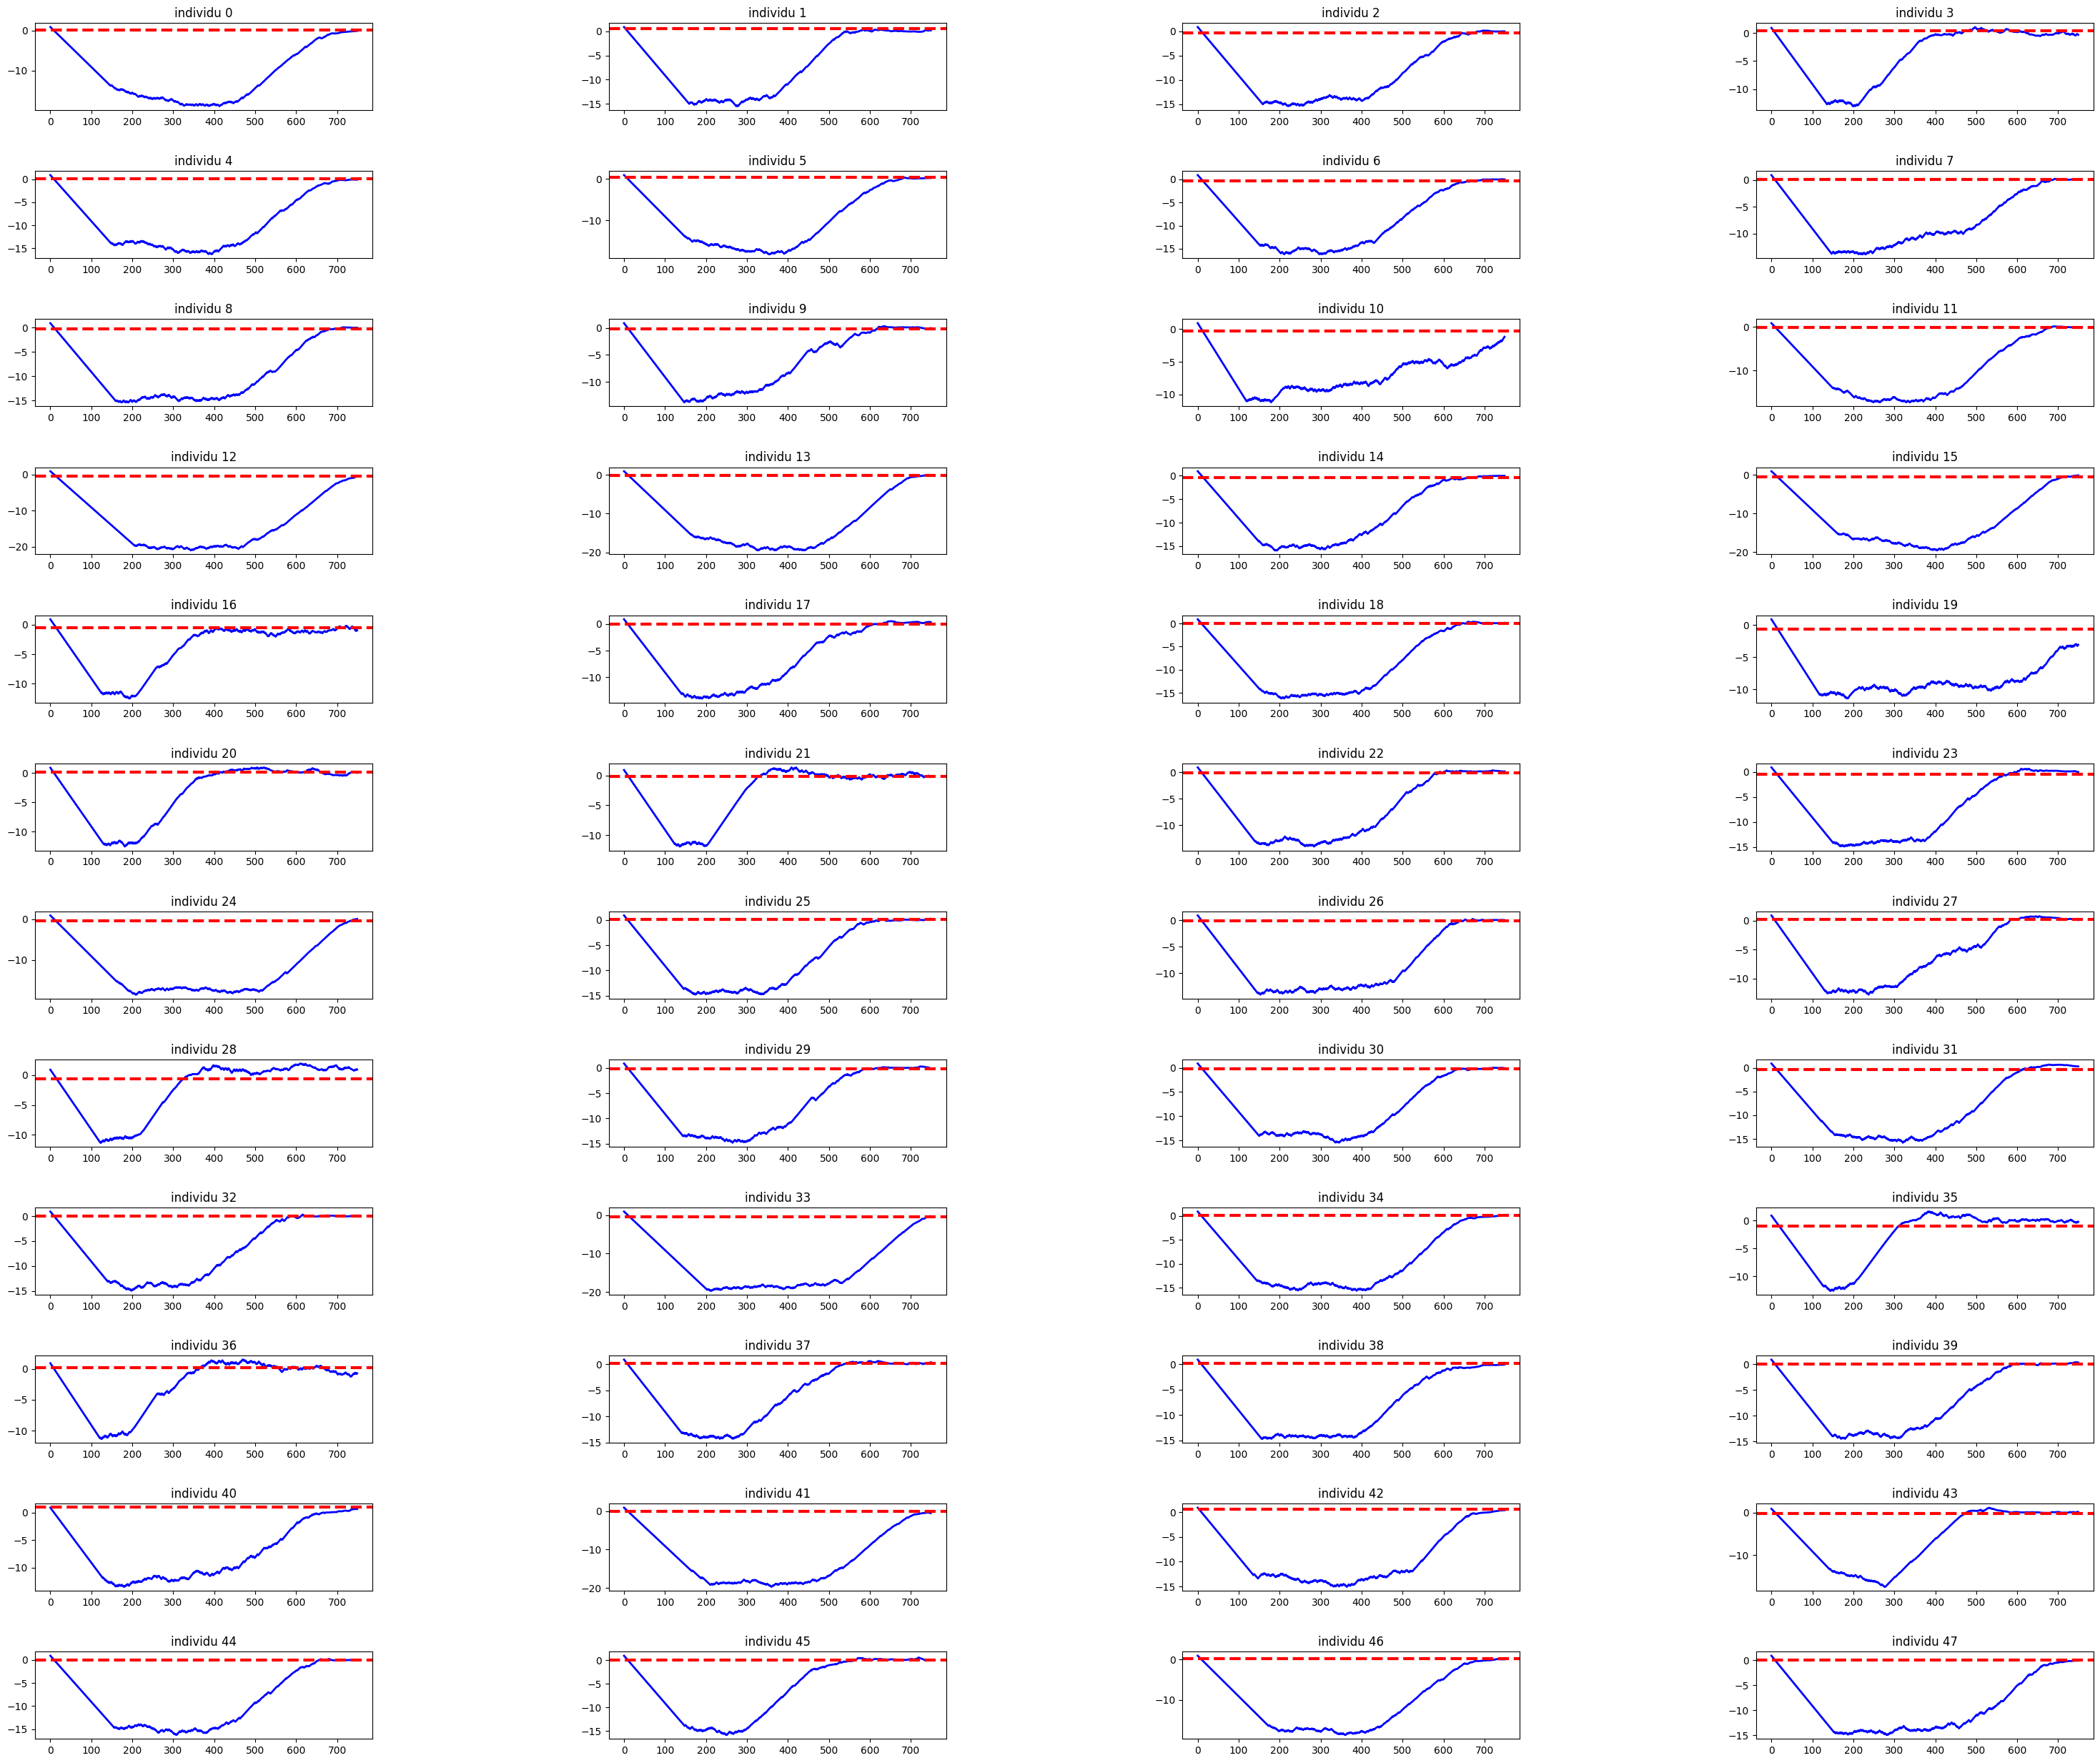

In [46]:
r_ar = jnp.array(logr_liste)
r2_ar = jnp.array(logr_liste2)
rcst_ar = jnp.array(logr_liste_cst)

nrow = 12
ncol = 4

fig, axes = plt.subplots(nrow, ncol, figsize=(36,30))

axes = axes.flatten()
# Boucle à travers chaque base de données et chaque axe
for i in range(48):
    ax = axes[i]
    #ax.plot(r_ar[:, i], color = 'green', linewidth = 2)
    ax.plot(rcst_ar[:, i], color = 'blue', linewidth = 2)
    #ax.plot(r2_ar[:, i], color = 'green', linewidth=2)

    

    ax.axhline( lrt_is[i], linestyle ='--' ,color = 'red', linewidth = 3)
    ax.set_title(f'individu {i}', fontsize = 12)
        
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.7, hspace=0.7)

plt.savefig("saris/tous_les_indiv.png", dpi=300)


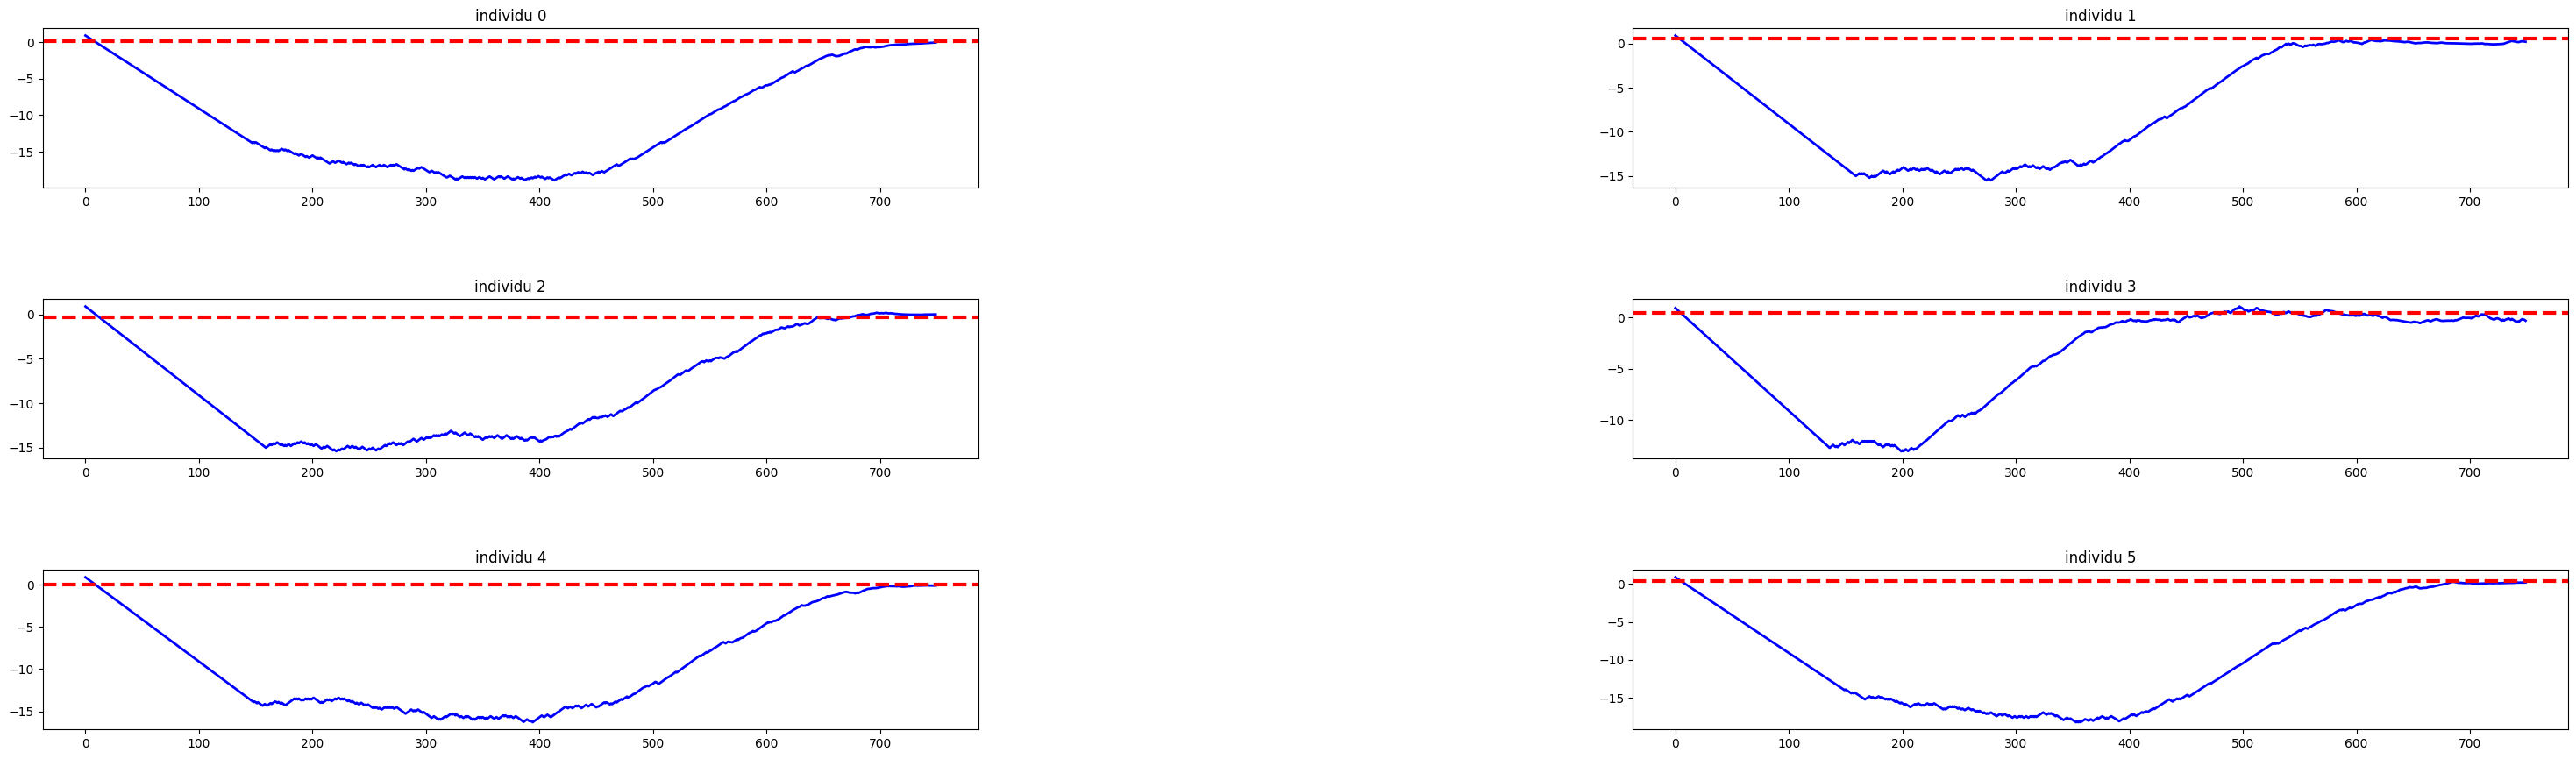

In [51]:

nrow = 3
ncol = 2

fig, axes = plt.subplots(nrow, ncol, figsize=(36,10))

axes = axes.flatten()
# Boucle à travers chaque base de données et chaque axe
for i in range(6):
    ax = axes[i]
    #ax.plot(r_ar[:, i], color = 'blue')
    ax.plot(rcst_ar[:, i], color = 'blue', linewidth = 2)
    #ax.plot(r2_ar[:, i], color = 'red')

    

    ax.axhline( lrt_is[i], linestyle ='--' ,color = 'red', linewidth = 3)
    ax.set_title(f'individu {i}', fontsize = 12)
        
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.7, hspace=0.7)

plt.savefig("saris/quelques_indiv.png", dpi=300)

# real data

In [13]:
output_liste = ['TDW', 'RDW', 'TNQ', 'QNStor', 'LA', 'PLA',]


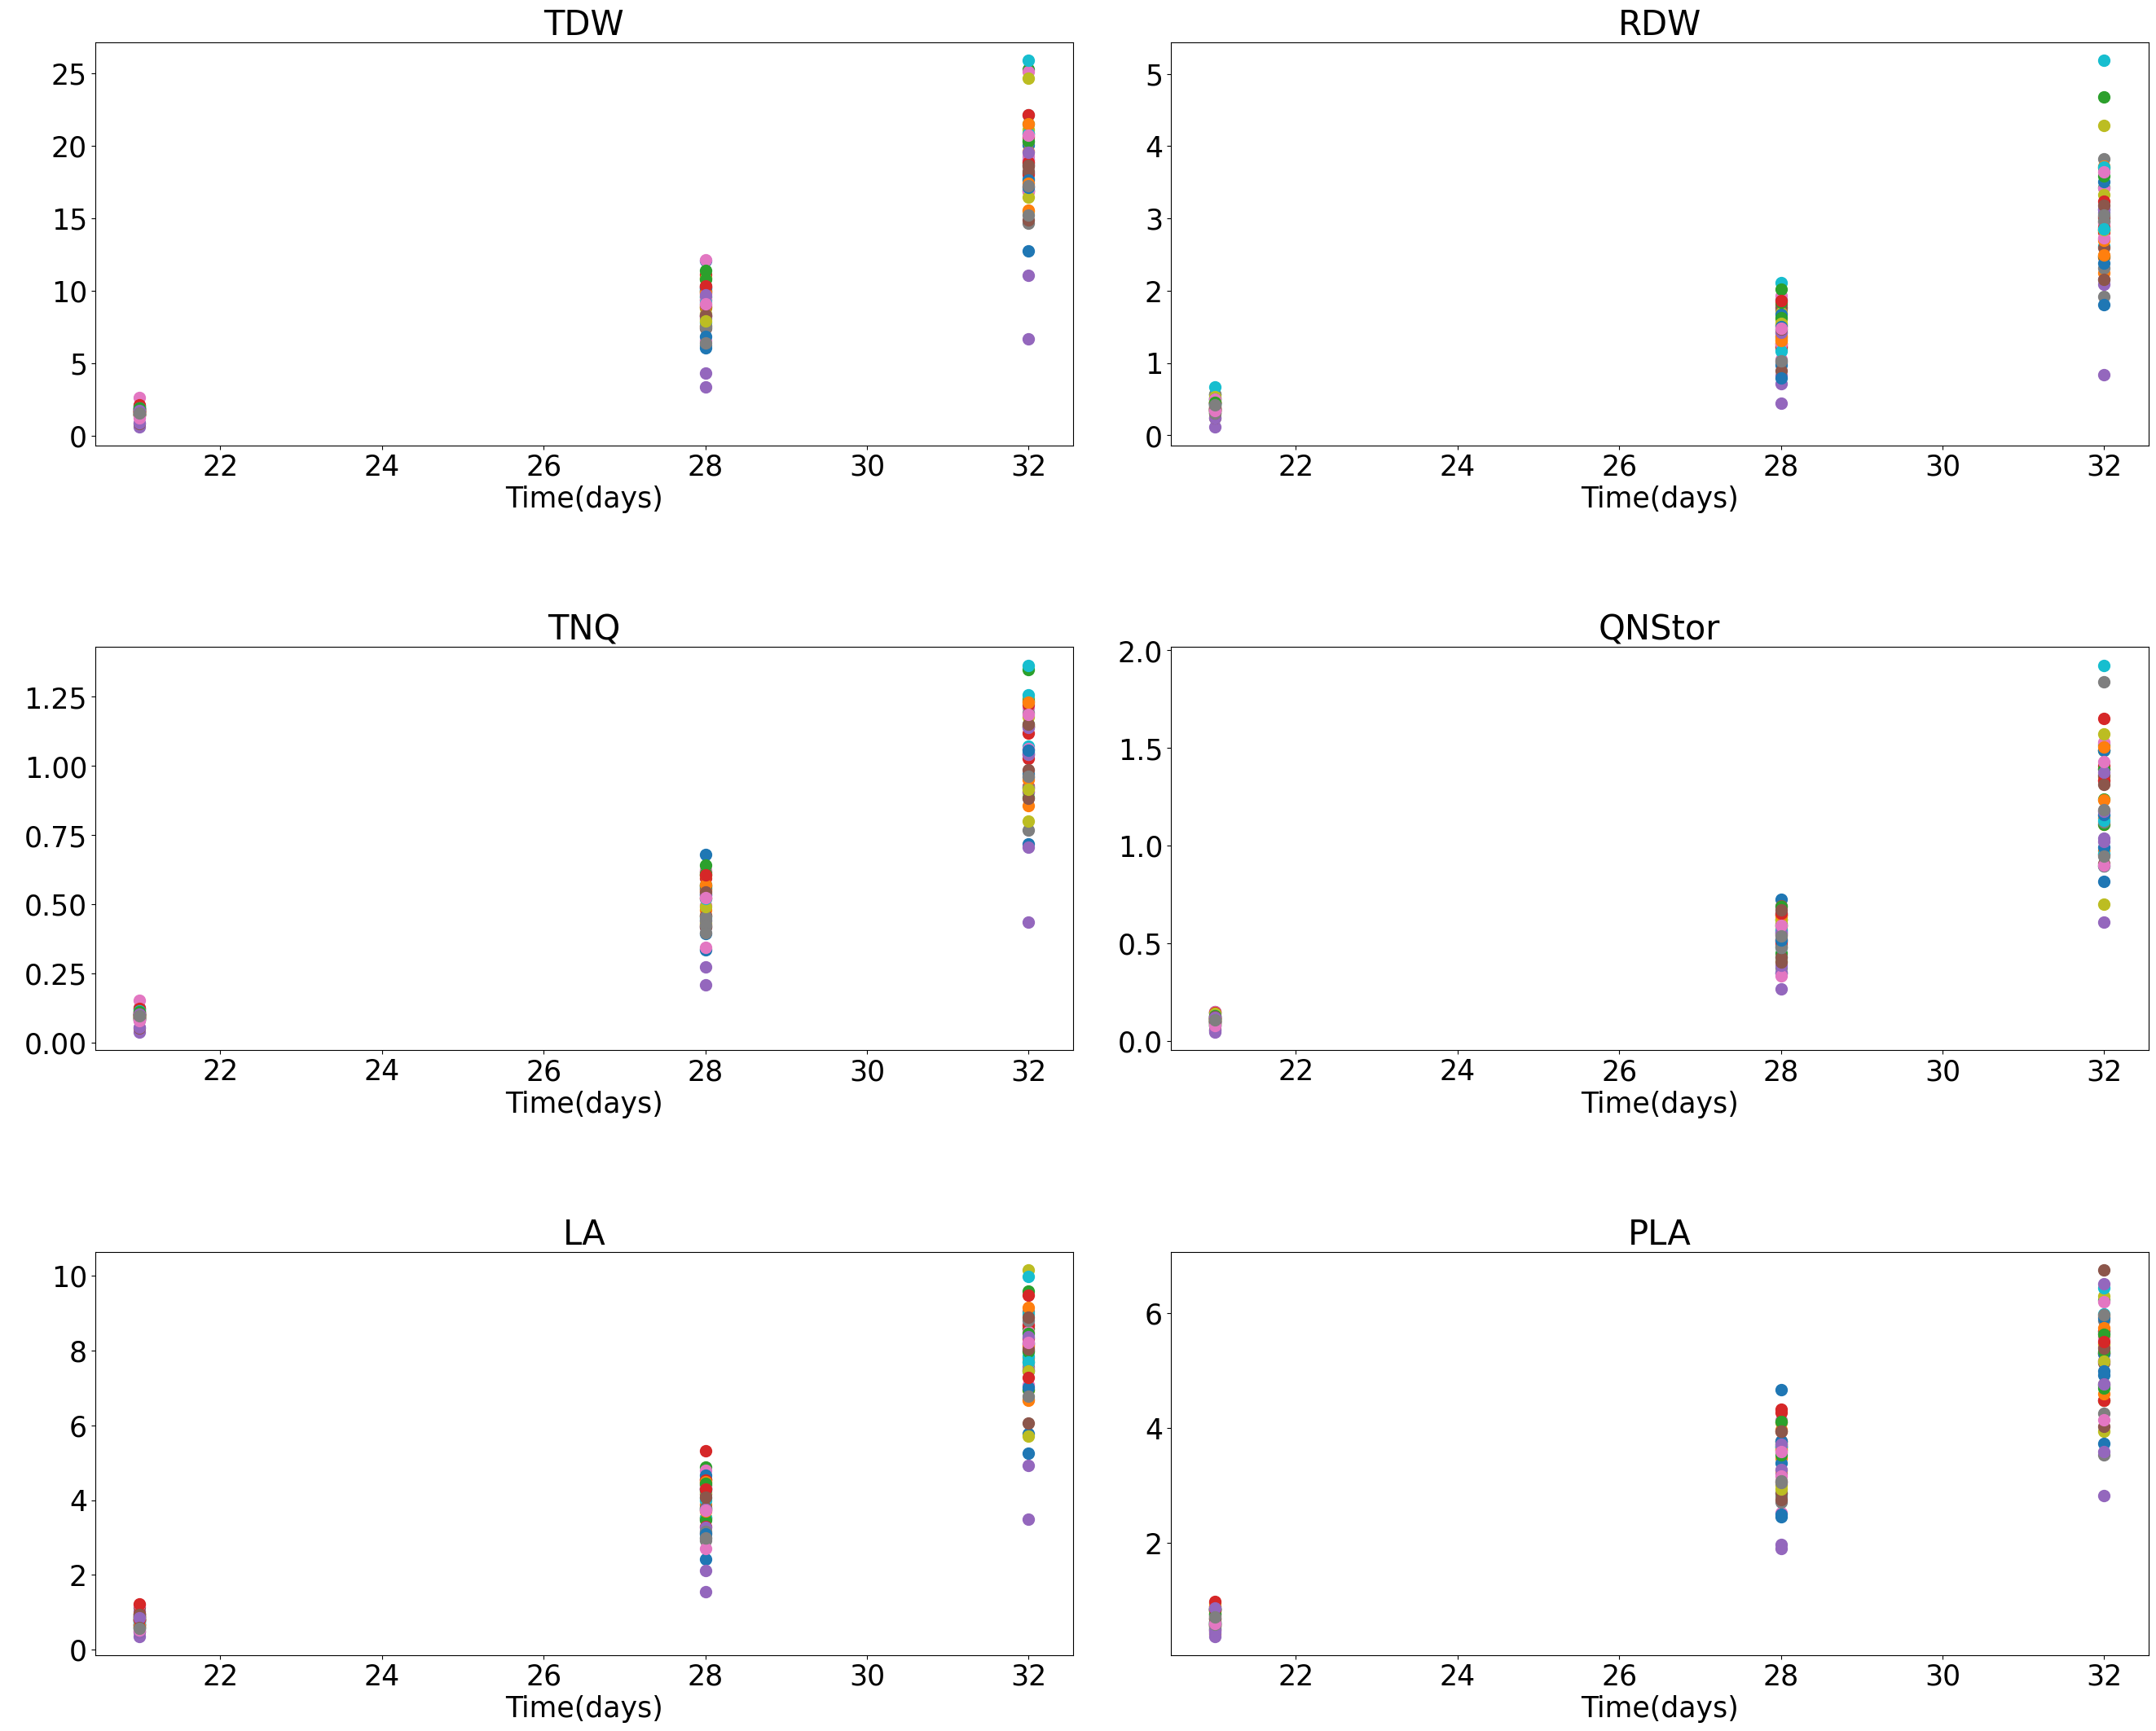

In [15]:
real_data_short = pd.read_csv('real_data.csv')
real_data_dict = {output : jnp.array(real_data_short[output]).reshape(48,3) for output in real_data_short.columns[2:]}
y_real_all = md.real_output_by_indiv(real_data_dict)

fig, axes = plt.subplots(3, 2, figsize=(28,22))

axes = axes.flatten()
# Boucle à travers chaque base de données et chaque axe
for i, o in enumerate(output_liste):
    
    ax = axes[i]
    for y in y_real_all : 
        ax.scatter([21, 28, 32], y[o], s=100)
        ax.set_title(o, fontsize = 30)
        ax.set_xlabel("Time(days)", fontsize = 25)
        ax.set_ylabel(" ")
        ax.tick_params(axis='both', which='major', labelsize=25)  # Augmenter la taille des graduations

        plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.1, hspace=0.5)
#        ax.grid(True)
#plt.savefig("outputs_plot.png", dpi=300)

In [73]:
res = single_estimation(0, y_real_all)

heating phase :


100%|██████████| 50/50 [00:01<00:00, 26.59it/s]


estimation :


100%|██████████| 750/750 [01:25<00:00,  8.74it/s]


In [22]:
# with open('real_data/estim_real.pkl', 'wb') as f:
#     pickle.dump(res, f)

with open('real_data/estim_real.pkl', 'rb') as f:
    res = pickle.load(f)

In [23]:
res.theta.shape

(750, 14)

In [24]:
res_theta_mean = [md.parametrization.reals1d_to_params(r) for r in res.theta]


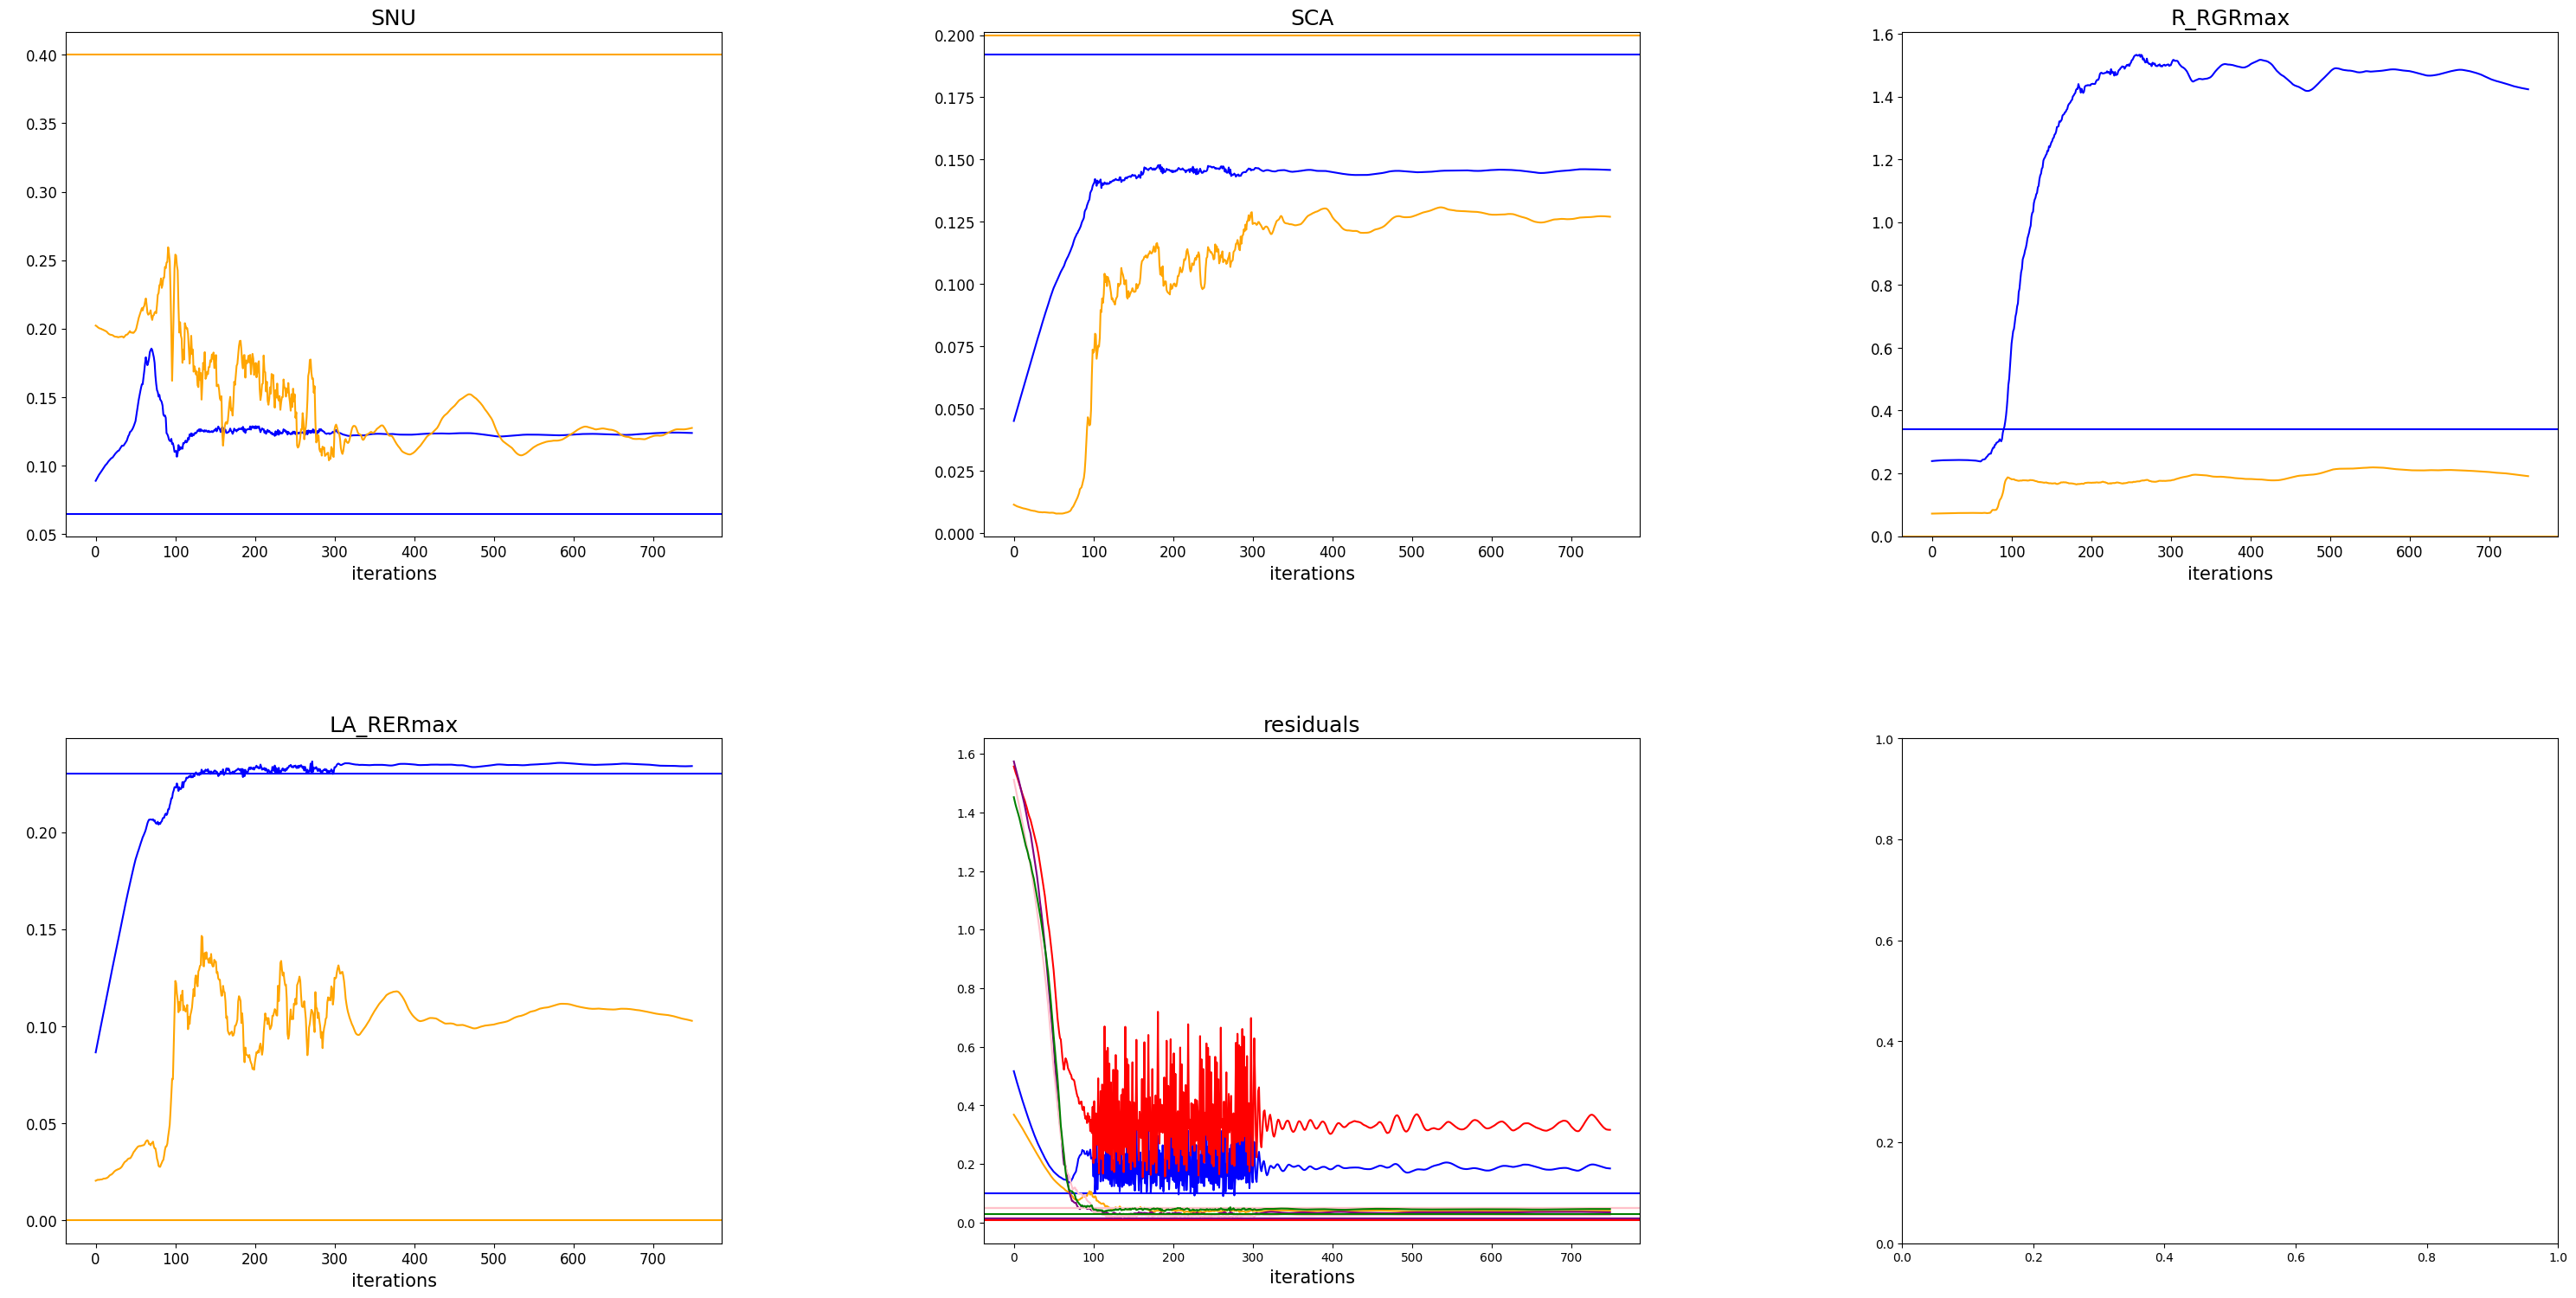

In [77]:

color_plot=['blue', 'orange', 'red', 'purple', 'pink', 'green']



fig, axes = plt.subplots(2, 3, figsize=(36,10))

axes = axes.flatten()



# Boucle à travers chaque base de données et chaque axe

for i, o in enumerate(md.estimation_description.indiv_model_parameters):
    
    ax = axes[i]
    
    ax.plot([getattr(md.base_params_model, md.estimation_description.indiv_model_parameters[i]).parametrization.reals1d_to_params(r.indiv.loc[i]) for r in res_theta_mean], color = 'blue')
    ax.plot([r.indiv.scale[i, i] for r in res_theta_mean], color = 'orange')
    
    ax.axhline(y=getattr(md.base_params_model, md.estimation_description.indiv_model_parameters[i]).default_value, color = 'blue')
    
    ax.axhline(y=param_star.indiv.scale[i, i], color = 'orange')
    ax.set_title(o, fontsize = 18)
    ax.set_xlabel("iterations", fontsize = 15)
    ax.set_ylabel(" ")
    ax.tick_params(axis='both', which='major', labelsize=12)  # Augmenter la taille des graduations


ax = axes[4]
for i in range(md.estimation_description.noutput):
    ax.plot([r.residual_var[i] for r in res_theta_mean], color=color_plot[i])
    ax.axhline(y = param_star.residual_var[i], color=color_plot[i])
ax.set_title("residuals", fontsize = 18)
ax.set_xlabel("iterations", fontsize = 15)
ax.set_ylabel(" ")



plt.subplots_adjust(left=0.1, right=0.9, top=1.5, bottom=0.1, wspace=0.4, hspace=0.4)

In [25]:
emv = md.parametrization.reals1d_to_params(res.theta[-1])
emv_1d = res.theta[-1]

In [28]:
emv_param = {}
for i, indiv in enumerate(md.estimation_description.indiv_model_parameters):
    emv_param[indiv] = getattr(
        md.base_params_model, indiv
    ).parametrization.reals1d_to_params(emv.indiv.loc[i])
emv_param

{'SNU': Array(0.1238693, dtype=float32),
 'SCA': Array(0.1458369, dtype=float32),
 'R_RGRmax': Array(1.4231733, dtype=float32),
 'LA_RERmax': Array(0.23409711, dtype=float32)}

In [10]:

values = {field: getattr(md.base_params_model, field).default_value for field in md.base_params_model._fields}
        # Object._fields returns a dictionary with every attribute of a dataclass or NamedTuple
        # Création d'un dictionnaire (mutable) values, qui pourra être modifié 
for i, indiv in enumerate(md.estimation_description.indiv_model_parameters):
    values[indiv] = getattr(
        md.base_params_model, indiv
    ).parametrization.reals1d_to_params(emv.indiv.loc[i])

emv_pop = model.ParamsModel(**values)

### $\varphi^{ref}$

In [11]:
param = md.ParamsModelDef(
    SNU=0.065,
    remob_NStor=0.037,
    remob_CStor=0,
    R_RGRmax=0.34,
    R_NCont_min=0.024,
    LA_RERmax=0.23,
    g=12.72,
    alpha=12.7,
    SCA=0.1921,
    k=0.085,
    Ccont=0.3856,
    LA_Ccost=0.54,
    DW_init=0.1,
    QN_init=0.007,
    LA_init=0.10,
    RT_ratio_init=0.20,
)

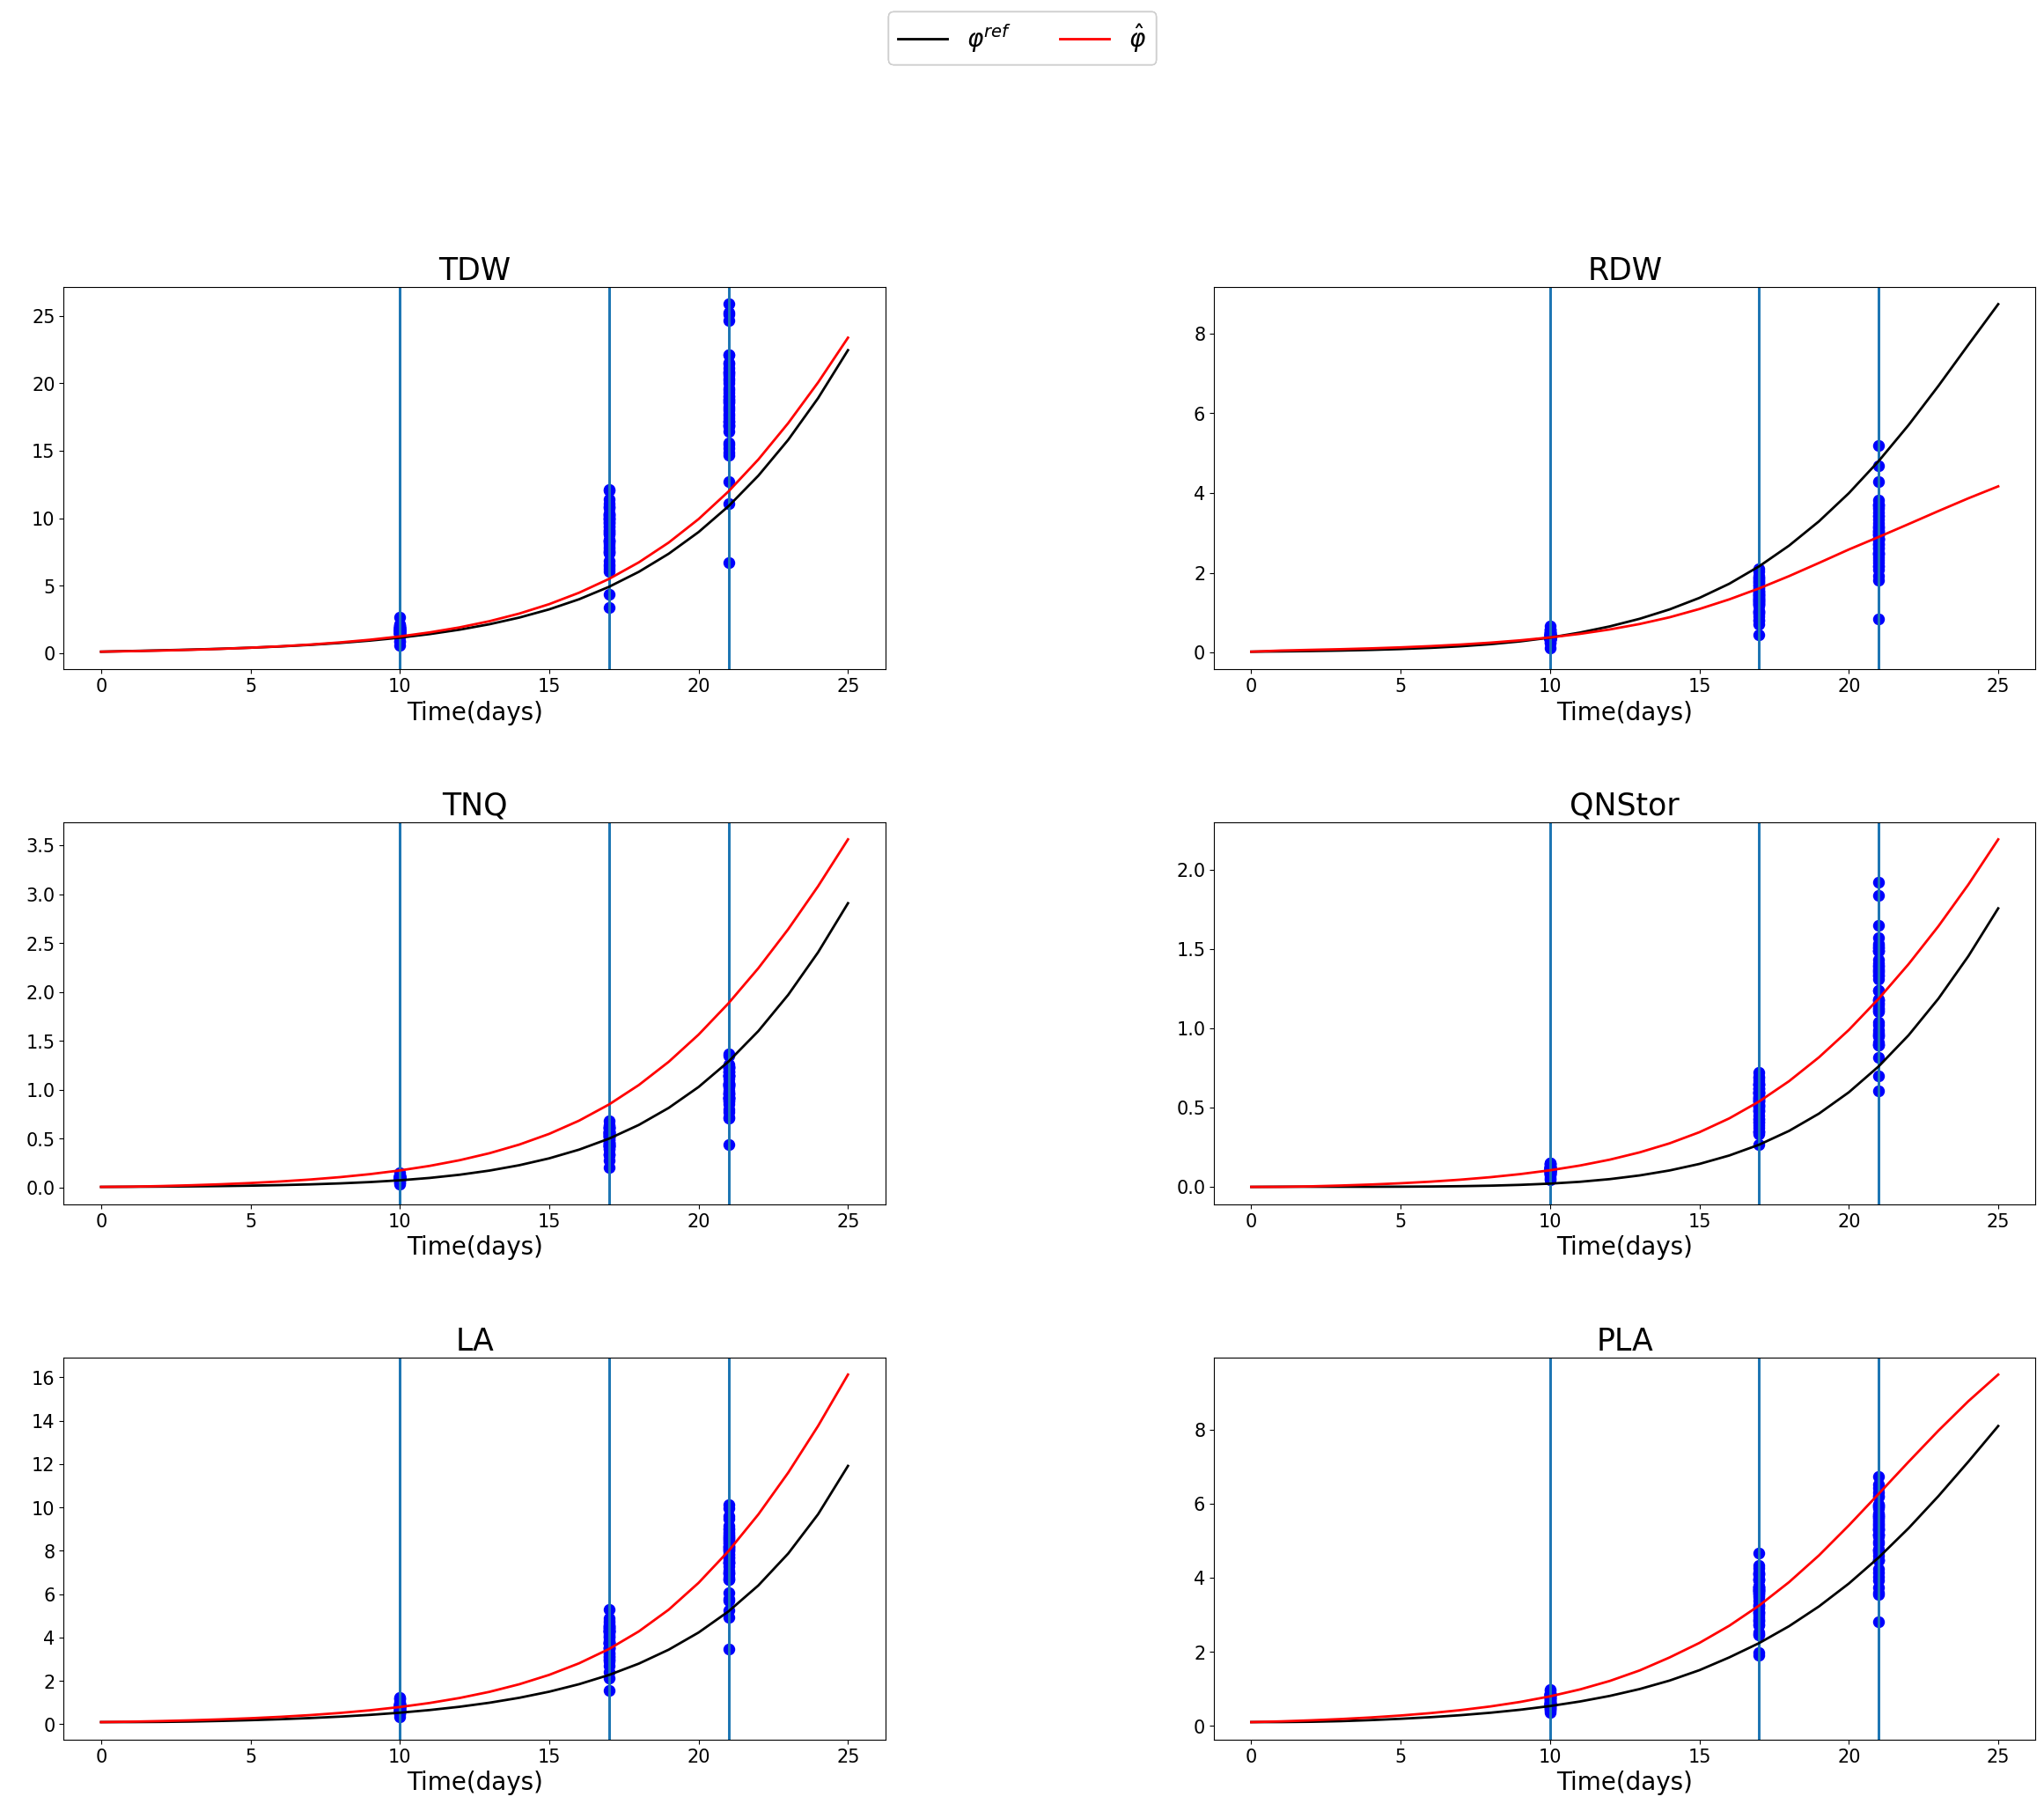

In [21]:

s=0.1

### affichage des données simulées
nombre_indiv = 48 

y_real_pop = model.run(emv_pop, 25)
y_pop_mean = model.run(param, 25)


fig, axes = plt.subplots(3, 2, figsize=(28,22))

axes = axes.flatten()
# Boucle à travers chaque base de données et chaque axe
for i, o in enumerate(output_liste):
    
    ax = axes[i]
    for y in y_real_all : 
        ax.scatter([10, 17, 21], y[o], s = 75, color = 'b')

        ax.set_title(o, fontsize = 25)
        ax.set_xlabel("Time(days)", fontsize = 20)
        ax.set_ylabel(" ")
        ax.tick_params(axis='both', which='major', labelsize=15)  # Augmenter la taille des graduations
        ax.axvline(x=10, linewidth = 1)
        ax.axvline(x=17, linewidth = 1)
        ax.axvline(x=21, linewidth = 1)
    ax.plot([getattr(s, o) for s in y_pop_mean], label = r"$\varphi^{ref}$", linewidth = 2, color = 'black')
    ax.plot([getattr(s, o) for s in y_real_pop], label = r"$\hat{\varphi}$", linewidth = 2, color = 'red')
    
    plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.1, wspace=0.4, hspace=0.4)
    # Ajout de la légende commune
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=20)
    #        ax.grid(True)
    plt.savefig("real_data/comp_est_ref.png", dpi=300)




In [103]:
K = 1000
prng_key = jax.random.PRNGKey(123)

res_z = []

sigma_proposal = jnp.ones((nombre_indiv, p))
current_acc = jnp.ones((nombre_indiv, p)) * 0.4
z = jnp.zeros(shape = (n, p))

for step in tqdm(range(K)):

    key, prng_key = jax.random.split(prng_key)
    (sigma_proposal, current_acc, z, ll) = md.mh_step_adaptative_indiv(
        emv_1d,
        z,
        y_real_all,
        sigma_proposal,
        current_acc,
        step,
        key,
    )

    res_z.append(z)




100%|██████████| 1000/1000 [00:39<00:00, 25.43it/s]


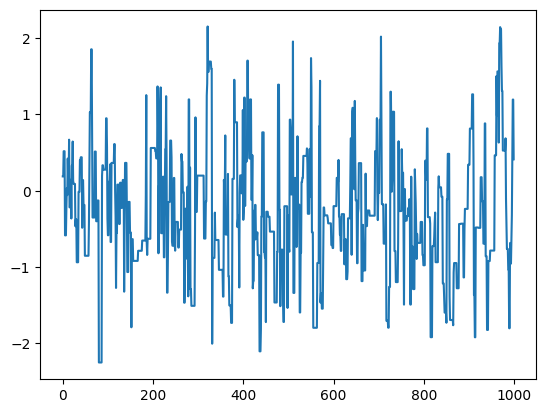

In [104]:
plt.plot(jnp.array([r[0,0] for r in res_z]))

In [105]:
z_est = jnp.mean(jnp.array(res_z)[3:,:,:], axis = 0)

In [107]:
estimation_description_2 = md.EstimationDescription(
    indiv_model_parameters=md.estimation_description.indiv_model_parameters,
    population_model_parameters=(),
    outputs=(
        md.Output("TDW", tuple([i for i in range(25)])),
        md.Output("RDW", tuple([i for i in range(25)])),
        md.Output("TNQ", tuple([i for i in range(25)])),
        md.Output("QNStor", tuple([i for i in range(25)])),
        md.Output("LA", tuple([i for i in range(25)])),
        md.Output("PLA", tuple([i for i in range(25)])),
    ),
)

In [109]:
y_pred = []
for i in range(n):

    params_model_indiv = md.base_params_model.get_params_model_indiv(
        estimation_description_2, emv, z_est[i]
    )

    list_of_state = md.run(
        params_model=params_model_indiv,
        n_days=25,
    )

    y_pred.append(list_of_states_to_output(list_of_state,estimation_description_2))


In [110]:
y_real_all[0]

{'TDW': Array([ 1.8015  , 12.055125, 18.1565  ], dtype=float32),
 'RDW': Array([0.5665  , 1.877375, 2.8405  ], dtype=float32),
 'TNQ': Array([0.104922  , 0.6786833 , 0.97068036], dtype=float32),
 'QNStor': Array([0.14450072, 0.724489  , 0.8956464 ], dtype=float32),
 'LA': Array([0.6466437, 4.307358 , 5.781393 ], dtype=float32),
 'PLA': Array([0.5990147, 4.6647005, 4.927901 ], dtype=float32)}

In [ ]:
liste_indiv_pred = [6, 7, 10, 12, 16, 18, 19, 34, 35, 41]


In [158]:
liste_indiv_pred = [6, 7, 10, 12, 16]

color_indiv = plt.get_cmap('tab5').colors
output_pred = ['RDW', 'QNStor']


ValueError: 'tab5' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

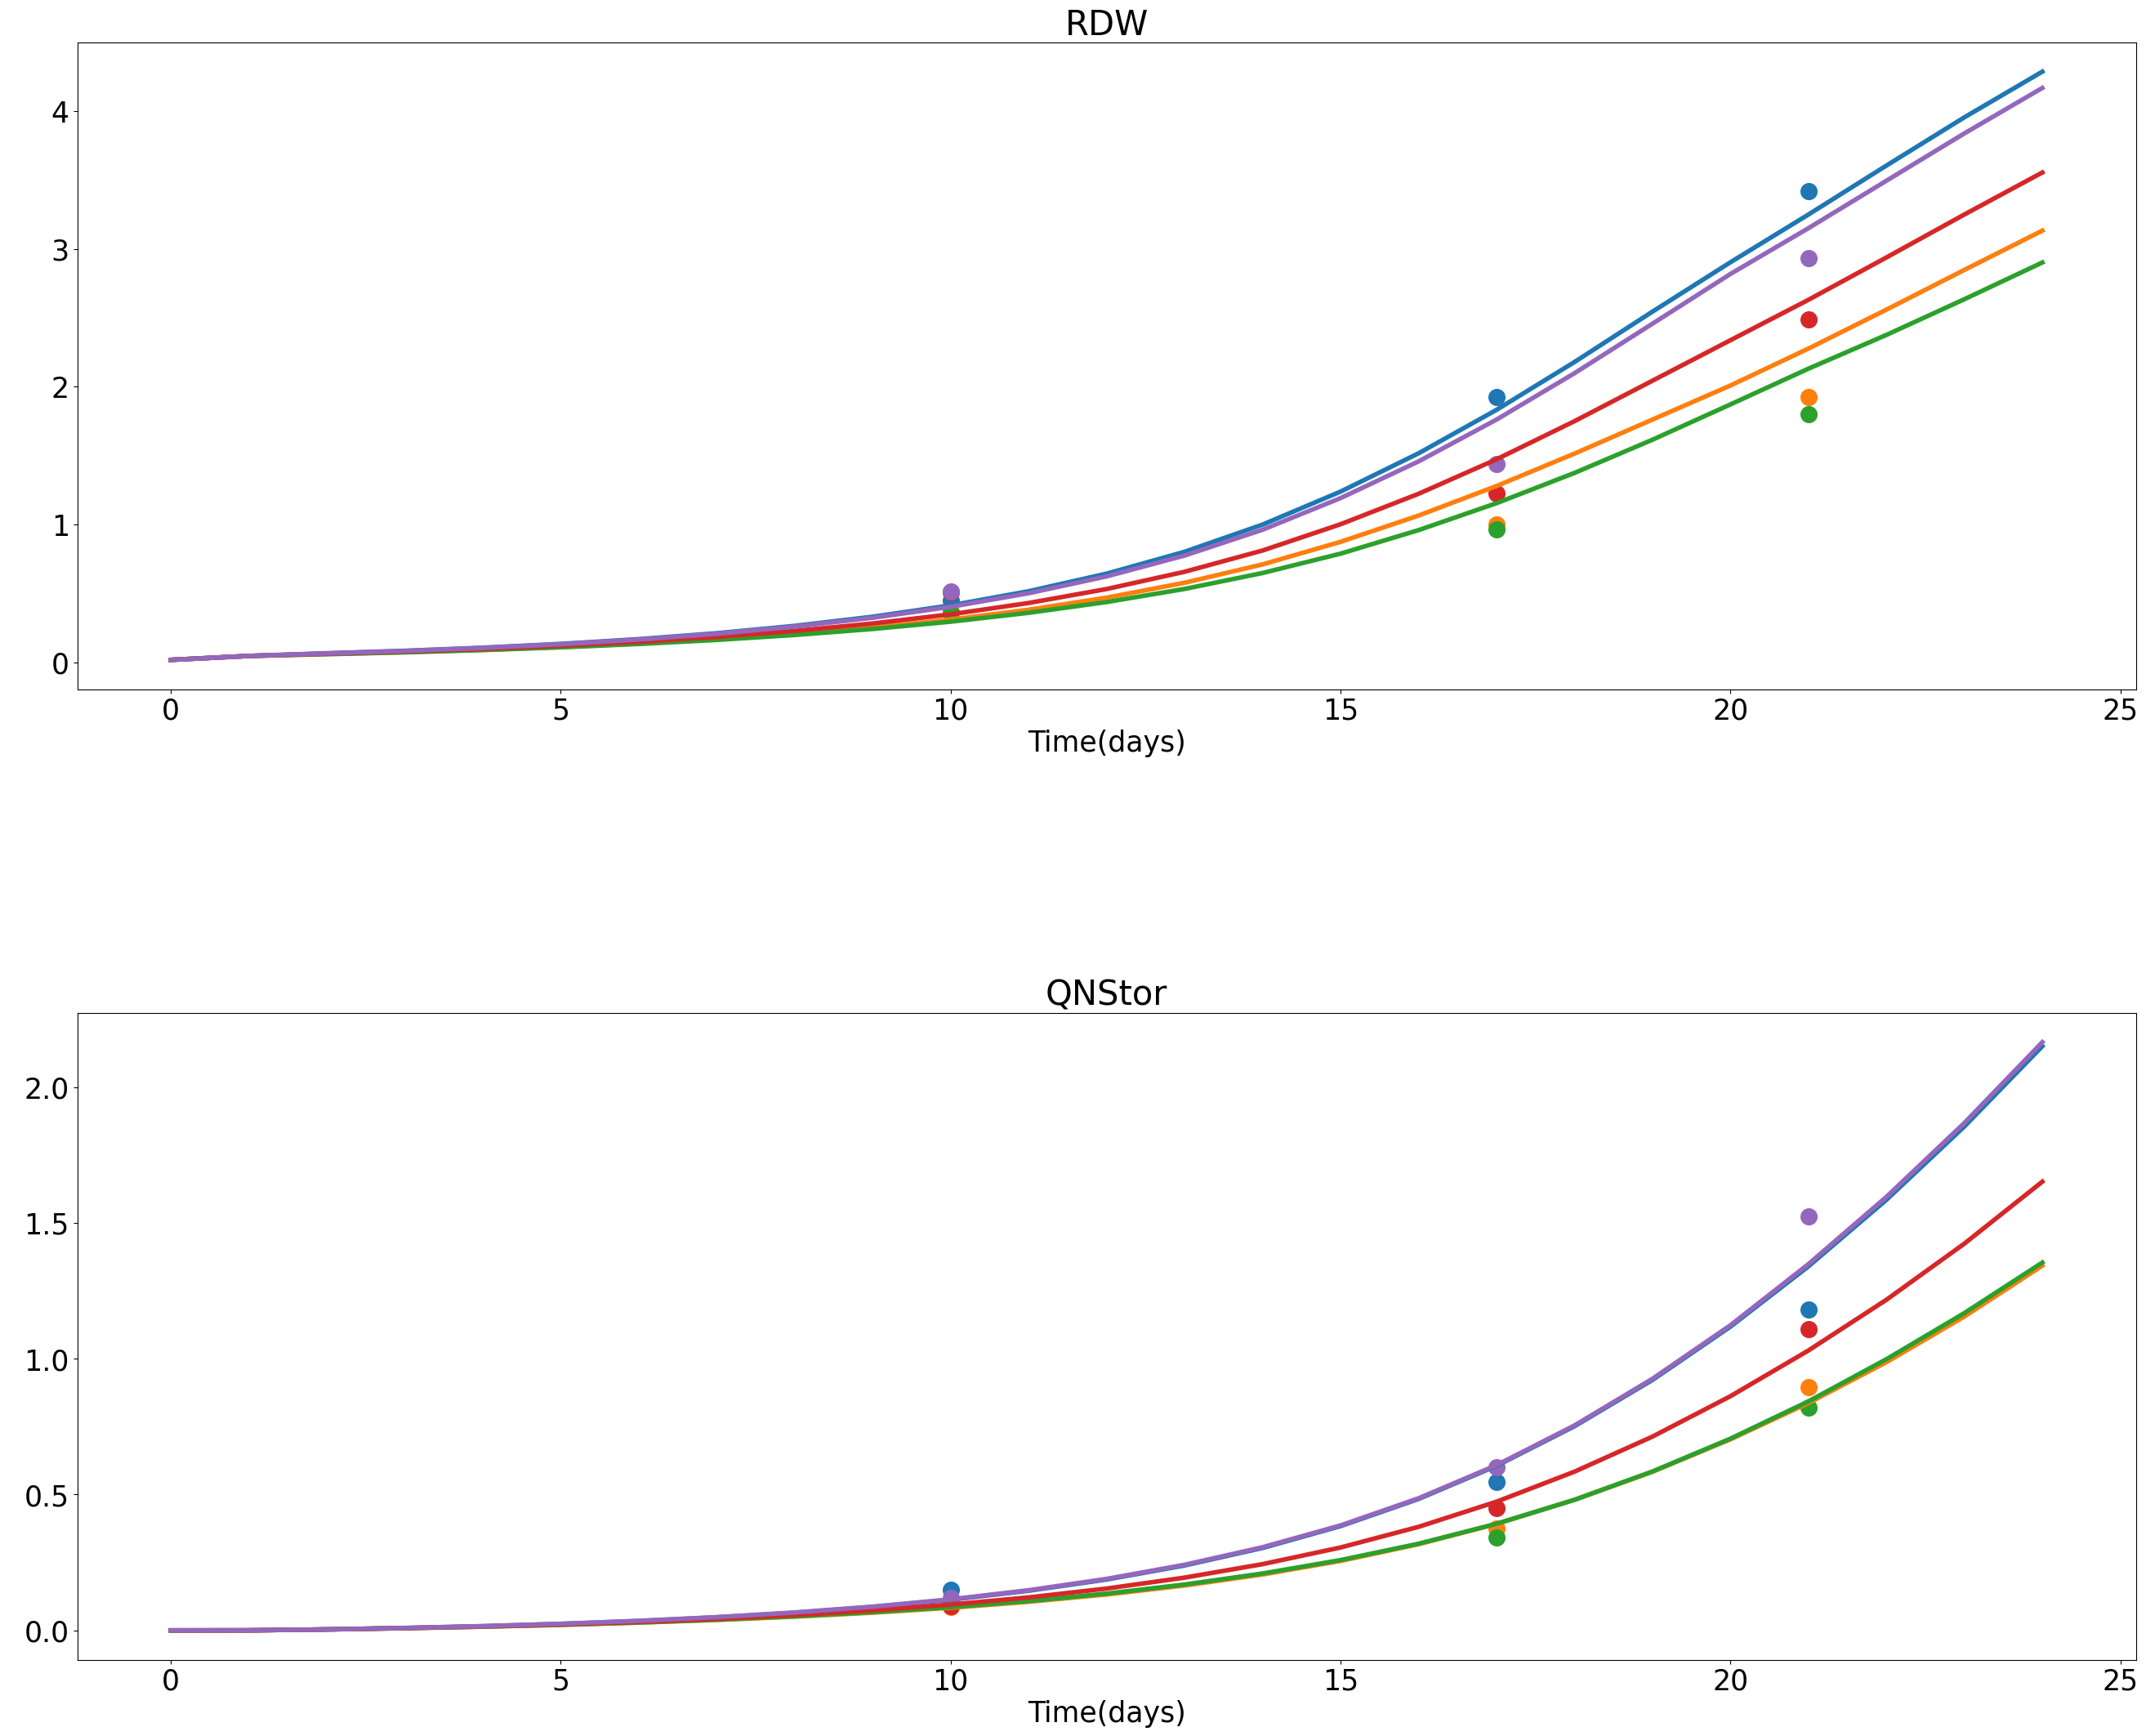

In [161]:

fig, axes = plt.subplots(2, 1, figsize=(28,22))

axes = axes.flatten()
# Boucle à travers chaque base de données et chaque axe

first = True

for i, o in enumerate(output_pred):
    
    ax = axes[i]

    for l in range(len(liste_indiv_pred)) : 

        ax.scatter([10, 17, 21], y_real_all[liste_indiv_pred[l]][o], s = 200, color = color_indiv[l], label='True data')
        ax.plot(y_pred[liste_indiv_pred[l]][o],color = color_indiv[l], linewidth = 4)

        ax.set_title(o, fontsize = 30)
        ax.set_xlabel("Time(days)", fontsize = 25)
        ax.set_ylabel(" ")
        ax.tick_params(axis='both', which='major', labelsize=25)  # Augmenter la taille des graduations

        
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.1, hspace=0.5)
plt.savefig("real_data/pred_indiv.png", dpi=300)